# Рынок вакансий для аналитиков данных и системных аналитиков в 2024 году

## Описание
Выявить различия в предлагаемых вакансиях для аналитиков данных и системных аналитиков по заказу кадрового агентства.

## Цель
* Провести предобработку данных
* Выявление грейда требуемых специалистов по названию вакансии или по колонке с требуемым опытом
* Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Системный аналитик
* Определение типичного места работы для Аналитика данных и Системного аналитика по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы в разрезе грейдов Junior, Junior+, Middle, Senior
* Определение, какие навыки спрашивают чаще - твердые или мягкие. К какому грейду и к какой специальности требований больше
* Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Системный аналитик по следующим параметрам: самые важные hard-skils, самые важные soft-skils в разрезе грейдов Junior, Junior+, Middle, Senior
* Формулирование выводов и рекомендаций

In [1]:
# Подключаем библиотеки
import pandas as pd
import requests
import urllib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import textwrap

from textwrap import wrap
from scipy.stats import spearmanr

In [2]:
# Публичная ссылка на файлы с данными
folder_url = 'https://yadi.sk/d/eA4zuI8qPag-KQ'

# Задаем имена файлов
file_url1, file_url2 = ('vacancies_sa.xlsx', 'vacancies_da (1).xlsx')

# Готовим ссылки для скачивания
url1 = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url1)
url2 = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url2)

# Создаем запрос ссылки на скачивание
r1, r2 = (requests.get(url1), requests.get(url2)) 

#'Парсим' ссылки на скачивание
h1, h2 = (json.loads(r1.text)['href'], json.loads(r2.text)['href'])

In [3]:
# Сохраняем загруженные файлы в датафреймы при первом запуске 
# copy_1, copy_2 = (
#         pd.read_excel(h1),
#         pd.read_excel(h2)
# )

# Сохраняем копии файлов на диске при первом запуске
# copy_1.to_csv(f'/home/misha/Dev/jupyterlab/practicum/project/00 — datasets/vacancies_sa.csv', encoding='utf-8-sig', sep=';', index=False)
# copy_2.to_csv(f'/home/misha/Dev/jupyterlab/practicum/project/00 — datasets/vacancies_da.scv', encoding='utf-8-sig', sep=';', index=False)

## Чтение данных

In [4]:
# Запускаем локальную версию файла
try:
    sa, da = (
        pd.read_csv('/home/misha/Dev/jupyterlab/practicum/project/00 — datasets/vacancies_sa.csv'), # системные аналитики
        pd.read_csv('/home/misha/Dev/jupyterlab/practicum/project/00 — datasets/vacancies_da.csv'), # аналитики данных
)

# Если ошибка с локальным файлом, то запускаем из Яндекс.диска
except:
    sa, da = (
        pd.read_excel(h1), # аналитики данных
        pd.read_excel(h2), # системные аналитики
)

Мы видим две таблицы с одинаковым количеством колонок и названиями:

`id` — идентификатор вакансии;<br>
`name` — название вакансии;<br>
`published_at` — время публикации;<br>
`alternate_url` — адрес вакансии;<br>
`type` — тип вакансии (открытая);<br>
`employer` — название работодателя;<br>
`department` — название отдела работодателя;<br>
`area` — регион вакансии;<br>
`experience` — грейд, оценка уровня специалиста; <br>
`key_skills` — ключевые навыки;<br>
`schedule` — тип занятости;<br>
`employment` — график работы;<br>
`description` — описание вакансии;<br>
`description_lemmatized` — лемматизация описания;<br>
`salary_from` — зарплата от (нижняя граница);<br>
`salary_to` — зарплата до (верхняя граница);<br>
`salary_bin` — размер зарплаты;<br>
`key_skills_from_key_skills_field` — ключевые слова из ключевых навыков;<br>
`hard_skills_from_description` — ключевые навыки из описания вакансии;<br>
`soft_skills_from_description` — «мягкие» навыки из описания вакансии.<br>

In [5]:
# Обзор датасетов
display(da, sa)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",Полный день,Полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,ЗП не указана,NaN,NaN,Документация
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,99985864,Аналитик данных в отдел онлайн-маркетинга (мон...,2024-05-23 18:41:27,https://hh.ru/vacancy/99985864,Открытая,Леруа Мерлен,ИТ,Москва,Junior+ (1-3 years),"['Проактивность', 'Коммуникация', 'SQL', 'ad-h...",Гибкий график,Полная занятость,леруа мерлен — data-driven компания с передовы...,леруа мерлен data driven компания передовой ит...,NaN,NaN,ЗП не указана,"SQL, ad-hoc, A/B тесты, ETL, LTV, Python, Post...",NaN,"Коммуникация, Проактивность"
1797,99986822,Аналитик данных/специалист Excel,2024-06-10 18:58:20,https://hh.ru/vacancy/99986822,Открытая,СКАЙ БОНД,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Грамотная речь', 'Сводные таблицы', 'Сбор и ...",Удаленная работа,Полная занятость,sky bond – это агентство финансовых консультан...,sky bond агентство финансовый консультант евро...,50000.0,NaN,ЗП не указана,"Пользователь ПК, Работа в команде, Грамотная р...",NaN,NaN
1798,99988999,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:35:56,https://hh.ru/vacancy/99988999,Открытая,Марс,NaN,Ступино,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Гибкий график,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN
1799,99989203,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:40:04,https://hh.ru/vacancy/99989203,Открытая,Марс,NaN,Одинцово,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Полный день,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не у

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,NaN,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",Полный день,Полная занятость,юрент — это новый уровень городской мобильност...,юрент новый уровень городской мобильность круп...,NaN,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,NaN
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",Удаленная работа,Полная занятость,в surf уже 13 лет мы разрабатываем много разны...,surf 13 год разрабатывать разный продукт начин...,NaN,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",NaN,Документация
2,100059559,Системный IT аналитик,2024-07-08 11:48:17,https://hh.ru/vacancy/100059559,Открытая,AMarkets,NaN,Москва,Junior+ (1-3 years),['Документация'],Полный день,Полная занятость,"мы - международная fintech компания amarkets, ...",международный fintech компания amarkets 2 7 го...,233750.0,NaN,ЗП не указана,NaN,NaN,Документация
3,100063260,Системный Аналитик ERP-решений,2024-07-09 10:51:54,https://hh.ru/vacancy/100063260,Открытая,Астор,NaN,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",Удаленная работа,Полная занятость,компания «астор» с 2000 года занимается разраб...,компания астор 2 год заниматься разработка вне...,NaN,NaN,ЗП не указана,"ERP, 1С: Управление Торговлей, Atlassian Jira,...",confluence,Коммуникация
4,100064793,Системный аналитик,2024-07-08 16:39:40,https://hh.ru/vacancy/100064793,Открытая,Зетта Страхование,NaN,Москва,Junior+ (1-3 years),"['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...",Полный день,Полная занятость,обязанности: анализ задач развития и сопрово...,обязанность анализ задача развитие сопровожден...,NaN,NaN,ЗП не указана,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,99936919,Бизнес-аналитик / Системный аналитик (продукто...,2024-07-02 13:26:24,https://hh.ru/vacancy/99936919,Открытая,Первая Форма,NaN,Нижний Новгород,Junior+ (1-3 years),"['Документация', 'Коммуникация']",Удаленная работа,Полная занятость,"рассмотрим кандидатов со всех регионов рф, гот...",рассматривать кандидат весь регион рф готовый ...,NaN,NaN,ЗП не указана,NaN,NaN,"Коммуникация, Документация"
1911,99938797,Системный аналитик,2024-07-07 14:07:50,https://hh.ru/vacancy/99938797,Открытая,Газпром межрегионгаз инжиниринг,NaN,Санкт-Петербург,Junior+ (1-3 years),"['IDEF', 'Разработка технических заданий', 'RE...",Полный день,Полная занятость,"обязанности: сбор, анализ, обобщение, описани...",обязанность сбор анализ обобщение описание общ...,NaN,NaN,ЗП не указана,"IDEF, SQL, UML, BPMN, Разработка технических з...",NaN,Документация
1912,99951680,Ведущий системный аналитик 1С,2024-07-05 11:16:55,https://hh.ru/vacancy/99951680,Открытая,Novabev Group,Novabev Group. IT & E-Com,Владивосток,Middle (3-6 years),[],Удаленная работа,Полная занятость,"novabev group объединяет тех, кому важно расти...",novabev group объединять важно расти развивать...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
1913,99975404,Системный аналитик/System Analyst (junior),2024-07-07 15:12:34,https://hh.ru/vacancy/99975404,Открытая,Aston,NaN,Уфа,Junior+ (1-3 years),"['SOA', 'XML', 'Atlassian Jira', 'Use cases', ...",Удаленная работа,Полная занятость,системный аналитик / system analyst junior мы ...,системный аналитик system analyst junior аутсо...,80000.0,110000.0,От 100 тысяч до 200 тысяч,"Системный анализ, System Analysis, Use cases, ...",confluence,NaN


In [6]:
# Выводим информацию о значениях в датафреймах
display(da.info(), 
        sa.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1801 non-null   int64         
 1   name                              1801 non-null   object        
 2   published_at                      1801 non-null   datetime64[ns]
 3   alternate_url                     1801 non-null   object        
 4   type                              1801 non-null   object        
 5   employer                          1801 non-null   object        
 6   department                        521 non-null    object        
 7   area                              1801 non-null   object        
 8   experience                        1801 non-null   object        
 9   key_skills                        1801 non-null   object        
 10  schedule                          1801 non-null 

None

None

In [7]:
# Зададим новый столбец с типом вакансии
da['prof'] = 'da'
sa['prof'] = 'sa'

In [8]:
# Объеденияем датасеты в один датафрейм
df = pd.concat([sa, da], ignore_index=True, axis=0)

In [9]:
# Вывод объеденненого датафрейма
display(df)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,prof
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,NaN,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",...,Полная занятость,юрент — это новый уровень городской мобильност...,юрент новый уровень городской мобильность круп...,NaN,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,NaN,sa
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",...,Полная занятость,в surf уже 13 лет мы разрабатываем много разны...,surf 13 год разрабатывать разный продукт начин...,NaN,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",NaN,Документация,sa
2,100059559,Системный IT аналитик,2024-07-08 11:48:17,https://hh.ru/vacancy/100059559,Открытая,AMarkets,NaN,Москва,Junior+ (1-3 years),['Документация'],...,Полная занятость,"мы - международная fintech компания amarkets, ...",международный fintech компания amarkets 2 7 го...,233750.0,NaN,ЗП не указана,NaN,NaN,Документация,sa
3,100063260,Системный Аналитик ERP-решений,2024-07-09 10:51:54,https://hh.ru/vacancy/100063260,Открытая,Астор,NaN,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",...,Полная занятость,компания «астор» с 2000 года занимается разраб...,компания астор 2 год заниматься разработка вне...,NaN,NaN,ЗП не указана,"ERP, 1С: Управление Торговлей, Atlassian Jira,...",confluence,Коммуникация,sa
4,100064793,Системный аналитик,2024-07-08 16:39:40,https://hh.ru/vacancy/100064793,Открытая,Зетта Страхование,NaN,Москва,Junior+ (1-3 years),"['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...",...,Полная занятость,обязанности: анализ задач развития и сопрово...,обязанность анализ задача развитие сопровожден...,NaN,NaN,ЗП не указана,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",NaN,NaN,sa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,99985864,Аналитик данных в отдел онлайн-маркетинга (мон...,2024-05-23 18:41:27,https://hh.ru/vacancy/99985864,Открытая,Леруа Мерлен,ИТ,Москва,Junior+ (1-3 years),"['Проактивность', 'Коммуникация', 'SQL', 'ad-h...",...,Полная занятость,леруа мерлен — data-driven компания с передовы...,леруа мерлен data driven компания передовой ит...,NaN,NaN,ЗП не указана,"SQL, ad-hoc, A/B тесты, ETL, LTV, Python, Post...",NaN,"Коммуникация, Проактивность",da
3712,99986822,Аналитик данных/специалист Excel,2024-06-10 18:58:20,https://hh.ru/vacancy/99986822,Открытая,СКАЙ БОНД,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Грамотная речь', 'Сводные таблицы', 'Сбор и ...",...,Полная занятость,sky bond – это агентство финансовых консультан...,sky bond агентство финансовый консультант евро...,50000.0,NaN,ЗП не указана,"Пользователь ПК, Работа в команде, Грамотная р...",NaN,NaN,da
3713,99988999,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:35:56,https://hh.ru/vacancy/99988999,Открытая,Марс,NaN,Ступино,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",...,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN,da
3714,99989203,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:40:04,https://hh.ru/vacancy/99989203,Открытая,Марс,NaN,Одинцово,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",...,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN,da


## Предобработка

### Обработка дубликатов

In [10]:
# проверяем наличие явных дубликатов по индексу
df.duplicated().sum()

np.int64(0)

Явные дубликаты отсуствуют.

In [11]:
# Проверим наличие неявных дубликатов по всем поляем кроме id и alternate_url
df[df.duplicated(
    subset=[
            'name', 'type', 'employer', 
            'department','area', 'experience', 
            'key_skills', 'schedule','employment', 
            'description', 'salary_bin', 'prof'
           ],
    keep=False
    )].sort_values(by=[
                        'name', 'employer', 
                        'area', 'experience',
                        'key_skills', 'published_at'
                      ])


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,prof
3323,98088004,BI-аналитик/ Аналитик данных,2024-05-12 17:09:30,https://hh.ru/vacancy/98088004,Открытая,Сэлвим,NaN,Москва,Junior+ (1-3 years),['Pandas'],...,Полная занятость,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,da
1987,100463980,BI-аналитик/ Аналитик данных,2024-06-09 10:00:29,https://hh.ru/vacancy/100463980,Открытая,Сэлвим,NaN,Москва,Junior+ (1-3 years),['Pandas'],...,Полная занятость,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,da
2546,94702965,Data Analyst,2024-03-13 16:57:00,https://hh.ru/vacancy/94702965,Открытая,СБЕР,Сбер. Data Science,Москва,Junior+ (1-3 years),['Pandas'],...,Полная занятость,наша команда занимается разработкой и внедрени...,наш команда заниматься разработка внедрение ml...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,da
3260,97831652,Data Analyst,2024-04-24 16:47:53,https://hh.ru/vacancy/97831652,Открытая,СБЕР,Сбер. Data Science,Москва,Junior+ (1-3 years),['Pandas'],...,Полная занятость,наша команда занимается разработкой и внедрени...,наш команда заниматься разработка внедрение ml...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,da
2443,93826192,Data Analyst,2024-03-27 16:29:20,https://hh.ru/vacancy/93826192,Открытая,СБЕР,Сбер. Data Science,Москва,Junior+ (1-3 years),['Документация'],...,Полная занятость,в настоящее время сбербанк активно развивает н...,настоящий время сбербанк активно развивать нап...,NaN,NaN,ЗП не указана,NaN,NaN,Документация,da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,96494928,Старший аналитик данных (маркетинг),2024-04-09 09:38:57,https://hh.ru/vacancy/96494928,Открытая,Ozon,Ozon Офис и Коммерция,Москва,Middle (3-6 years),"['SQL', 'Python', 'Маркетинг, реклама, PR', 'М...",...,Полная занятость,чем предстоит заниматься: отслеживать и собир...,предстоять заниматься отслеживать собирать раз...,NaN,NaN,ЗП не указана,"Маркетинг, реклама, PR, аналитика данных, Pyth...",Pandas,NaN,da
2734,95548988,Урбан-аналитик данных,2024-03-26 15:33:29,https://hh.ru/vacancy/95548988,Открытая,Mayak,NaN,Москва,Junior+ (1-3 years),"['Английский язык', 'Анализ данных', 'Девелопм...",...,Частичная занятость,обязанности: • анализ рынка/субрынков коммерче...,обязанность анализ рынок субрынок коммерческий...,100000.0,NaN,ЗП не указана,"Маркетинговый анализ, Английский язык, GIS, Та...",NaN,Тайм-менеджмент,da
3662,99737480,Урбан-аналитик данных,2024-06-08 17:13:09,https://hh.ru/vacancy/99737480,Открытая,Mayak,NaN,Москва,Junior+ (1-3 years),"['Английский язык', 'Анализ данных', 'Девелопм...",...,Частичная занятость,обязанности: • анализ рынка/субрынков коммерче...,обязанность анализ рынок субрынок коммерческий...,100000.0,NaN,ЗП не указана,"Маркетинговый анализ, Английский язык, GIS, Та...",NaN,Тайм-менеджмент,da
3217,97652565,Эксперт-аналитик данных в группу цифрового аудита,2024-04-22 18:24:19,https://hh.ru/vacancy/97652565,Открытая,Recruitment Boutique S.M.Art,NaN,Москва,Junior+ (1-3 years),"['Аудит', 'Python', 'MS SQL']",...,Полная занятость,ищем эксперта со знанием инструментов анализа ...,искать эксперт знание инструмент анализ данные...,NaN,NaN,ЗП не указана,"Аудит, MS SQL, Python",NaN,NaN,da


In [12]:
# Удаляем дубликаты за исключением первого вхождения
df = df.drop_duplicates(
              subset=[
                      'name', 'type', 'employer', 
                      'department','area', 'experience', 
                      'key_skills', 'schedule','employment', 
                      'description', 'salary_bin', 'prof'
                     ], 
                keep='last'
              )

In [13]:
# Проверяем наличие неявных дубликатов по id и alternate_url
df[df.duplicated(subset=['id','alternate_url'], keep=False)]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,prof
31,100581829,Аналитик данных \ Системный аналитик,2024-06-27 12:04:15,https://hh.ru/vacancy/100581829,Открытая,Сеть Партнерств,NaN,Москва,Middle (3-6 years),"['SQL', 'Python', 'Документация', 'DWH', 'conf...",...,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.0,NaN,ЗП не указана,"SQL, Python, PostgreSQL, API, ETL, DWH, Базы д...",confluence,Документация,sa
32,100581830,Системный аналитик \ Аналитик данных,2024-06-27 12:12:35,https://hh.ru/vacancy/100581830,Открытая,Сеть Партнерств,NaN,Краснодар,Middle (3-6 years),"['confluence', 'Документация']",...,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.0,NaN,ЗП не указана,NaN,confluence,Документация,sa
33,100581831,Системный аналитик \ Аналитик данных,2024-07-05 09:28:01,https://hh.ru/vacancy/100581831,Открытая,Сеть Партнерств,NaN,Санкт-Петербург,Middle (3-6 years),"['confluence', 'Документация']",...,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.0,NaN,ЗП не указана,NaN,confluence,Документация,sa
1377,85053195,System analyst DWH,2024-07-01 10:11:06,https://hh.ru/vacancy/85053195,Открытая,Axenix (ранее Accenture),NaN,Краснодар,Junior+ (1-3 years),"['ORACLE', 'Airflow', 'SQL', 'Документация', '...",...,Полная занятость,компания axenix (ранее accenture) продолжает р...,компания axenix ранее accenture продолжать раб...,NaN,NaN,ЗП не указана,"SQL, DWH, Teradata, Hadoop, Airflow, Greenplum...",NaN,Документация,sa
1758,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-07-08 09:57:40,https://hh.ru/vacancy/98441008,Открытая,AVO.UZ,NaN,Москва,Junior+ (1-3 years),"['DWH', 'MS SQL', 'Системный анализ']",...,Полная занятость,команда avo services and technology создает по...,команда avo services and technology создавать ...,NaN,NaN,ЗП не указана,"DWH, MS SQL, Системный анализ",NaN,NaN,sa
2017,100581829,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581829,Открытая,Сеть Партнерств,NaN,Москва,Middle (3-6 years),"['SQL', 'API', 'Python', 'Документация', 'conf...",...,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.0,NaN,ЗП не указана,"SQL, Python, PostgreSQL, API, ETL, DWH, Базы д...",confluence,Документация,da
2018,100581830,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581830,Открытая,Сеть Партнерств,NaN,Краснодар,Middle (3-6 years),"['confluence', 'Документация']",...,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.0,NaN,ЗП не указана,NaN,confluence,Документация,da
2019,100581831,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581831,Открытая,Сеть Партнерств,NaN,Санкт-Петербург,Middle (3-6 years),"['confluence', 'Документация']",...,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.0,NaN,ЗП не указана,NaN,confluence,Документация,da
2259,85053195,System analyst DWH / Data Analyst,2024-06-03 09:36:32,https://hh.ru/vacancy/85053195,Открытая,Axenix (ранее Accenture),NaN,Краснодар,Junior+ (1-3 years),"['Teradata', 'SQL', 'Документация', 'Greenplum...",...,Полная занятость,компания axenix (ранее accenture) продолжает р...,компания axenix ранее accenture продолжать раб...,NaN,NaN,ЗП не указана,"SQL, DWH, Teradata, Hadoop, Airflow, Greenplum...",NaN,Документация,da
3376,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-06-11 09:57:39,https://hh.ru/vacancy/98441008,Открытая,AVO.UZ,N

In [14]:
# Удаляем неактуальные дубли
df = df.drop_duplicates(subset=['id','alternate_url'], keep='first')

**Вывод**

Явных дубликатов не найдено, а вот дубли с одинаковым id и url нашлись, а также дубли по названиям. По дате видим, что вакансии обновлялись и поэтому отразились в датасете.

### Обработка пропусков

In [15]:
# Изучим количество пропусков
df.isna().sum().sort_values()

id                                     0
salary_bin                             0
description_lemmatized                 0
description                            0
employment                             0
key_skills                             0
experience                             0
schedule                               0
employer                               0
type                                   0
alternate_url                          0
published_at                           0
name                                   0
area                                   0
prof                                   0
key_skills_from_key_skills_field    1253
soft_skills_from_description        1551
hard_skills_from_description        2559
department                          2694
salary_from                         2820
salary_to                           2998
dtype: int64

Пропуски обнаружены столбцах:
* department
* salary_from
* salary_to
* key_skills_from_key_skills_field
* hard_skills_from_description
* soft_skills_from_description

In [16]:
# Построим график
# пропущенные значения бары
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
          );    
    except:
        print('пропусков не осталось или произошла ошибка в первой части функции')    

<function matplotlib.pyplot.show(close=None, block=None)>

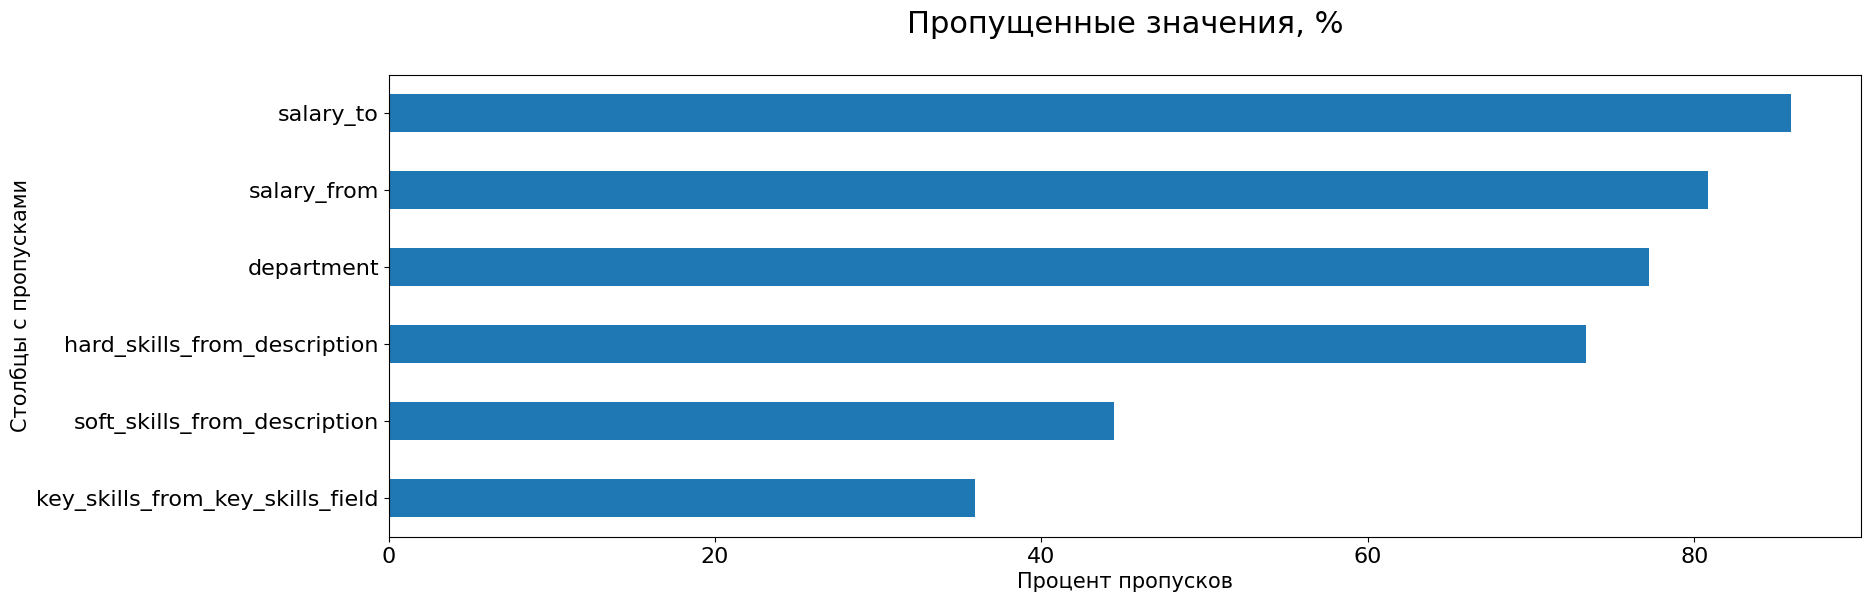

In [17]:
pass_value_barh(df)

# Добавим оформление
plt.title('Пропущенные значения, %' + "\n", fontsize = 22, color = 'Black')
plt.xlabel('Процент пропусков', fontsize = 15)
plt.ylabel('Столбцы с пропусками', fontsize = 15)

# Выводим график
plt.show

В данных наблюдается пропуски значений более 80% в столбцах `salary_to` и `salary_from`. С помощью библиотеки missingno проанализируем, где именно больше всего пропущенных значений.

<Axes: >

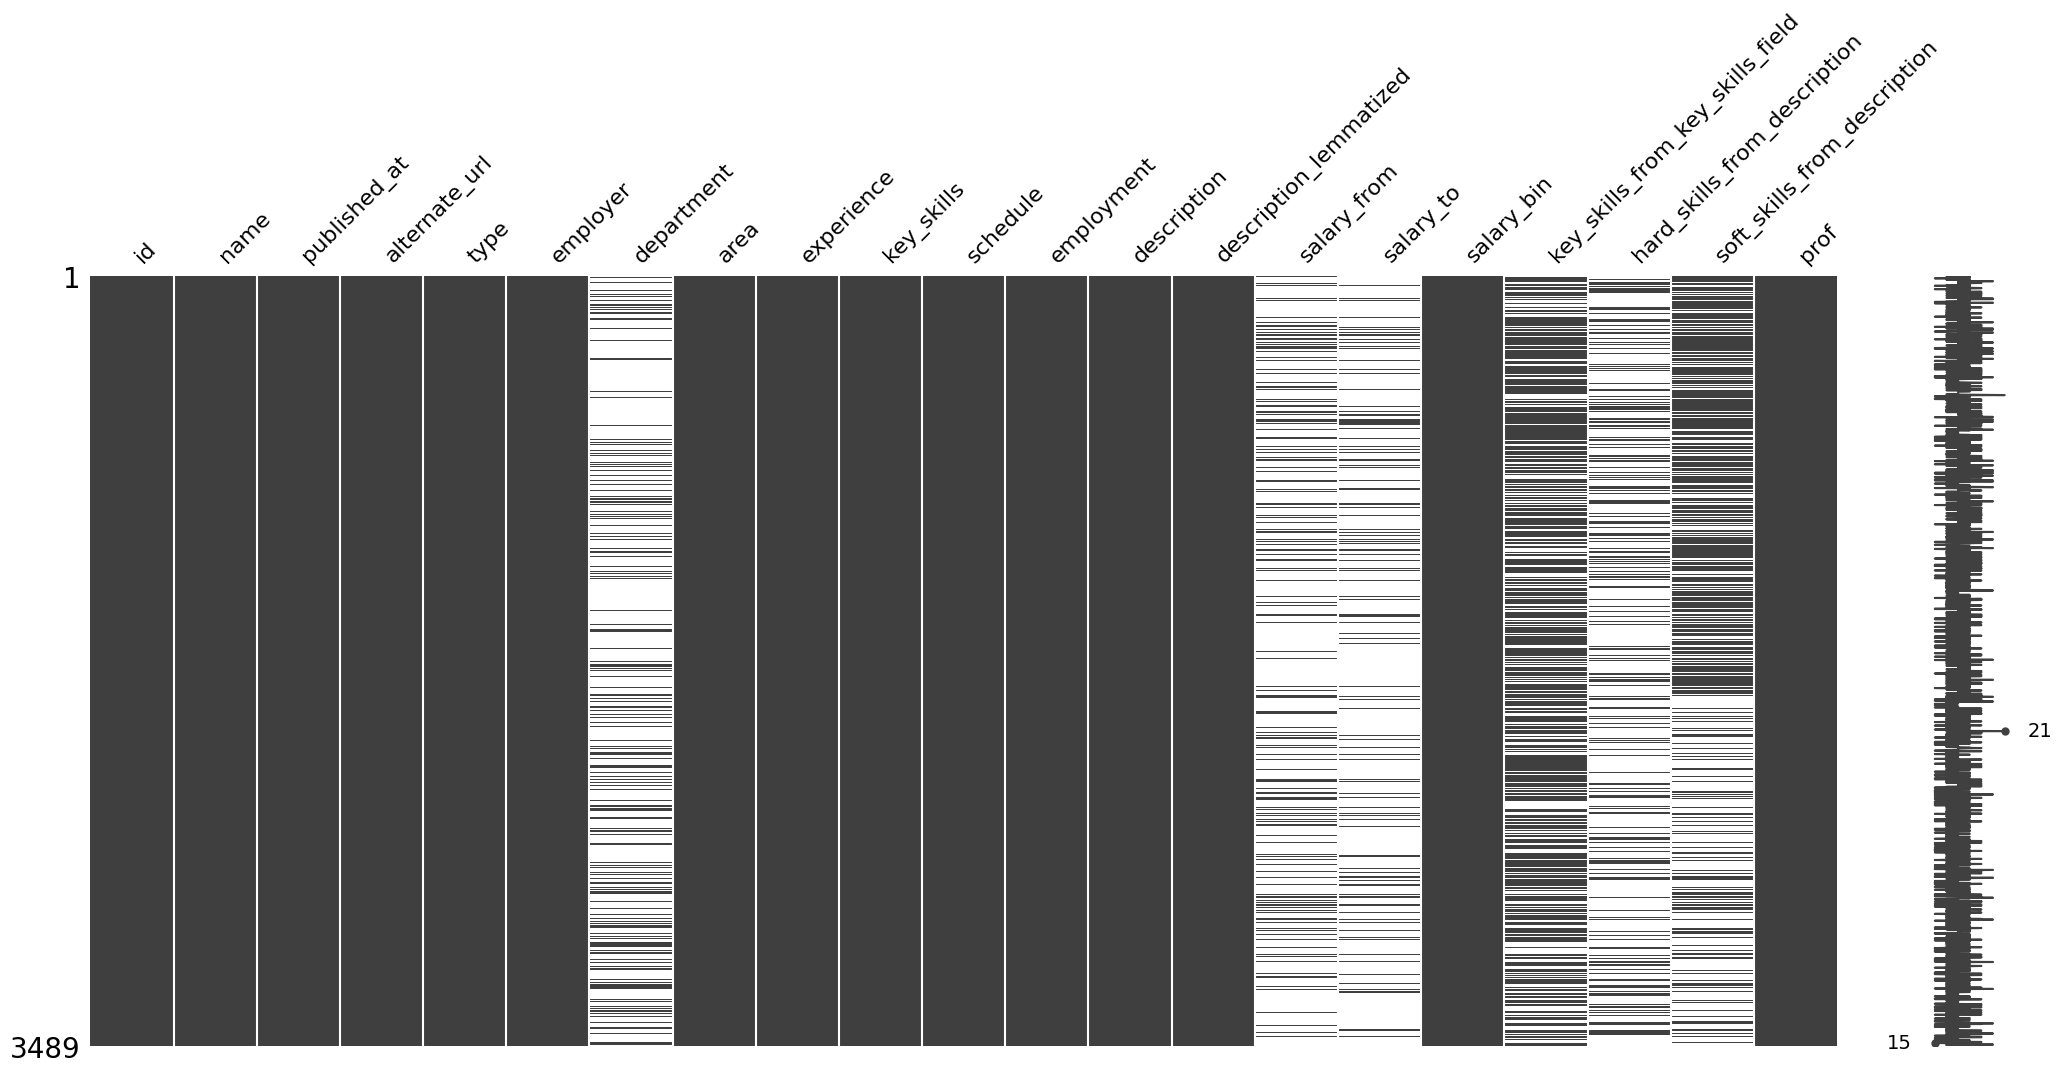

In [18]:
# Посмороим матрицу пропущенных значений
msno.matrix(df)

Распределение пропущенных значений в датасете выглядит случайным внутри столбцов. Но при этом есть несколько закономерностей:
* работодатели чаще заполняют верхнюю планку по зарплате, чем нижнюю;
* soft-скиллы указывают чаще, чем hard-скиллы.

Посмотрии на коррекляцию пропущенных значений:

In [19]:
# построим матрицу корреляции
df[['salary_from', 'salary_to', 
    'key_skills_from_key_skills_field', 
    'hard_skills_from_description', 
    'soft_skills_from_description'
   ]].isnull().corr()

,salary_from,salary_to,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
salary_from,1.000000,0.516827,0.118761,-0.071336,0.022559
salary_to,0.516827,1.000000,0.108807,-0.007227,0.050207
key_skills_from_key_skills_field,0.118761,0.108807,1.000000,-0.010823,0.057699
hard_skills_from_description,-0.071336,-0.007227,-0.010823,1.000000,0.076211
soft_skills_from_description,0.022559,0.050207,0.057699,0.076211,1.000000


Корреляция salary_from и  salary_to в 0.51 говорит о наличии связи, однако не слишком сильной. Выходит, что частота заполнения вехней планки не всегда сопровождается заполнением нижней планки. 

Починим пропуски в пропущенных значениях. Для столбца `department`все пропущенные можно заменить на значение по-умолчанию, так как удаление этих строк лишит нас почти всех данных.

In [20]:
# Обработаем пропущенные значения в столбцах
df = df.fillna(
                {
                'department':'неизвестно', 
                'key_skills_from_key_skills_field':'неизвестно',
                'hard_skills_from_description':'неизвестно',
                'soft_skills_from_description':'неизвестно'                
               }
)

In [21]:
# Проверим пропуски после обработки
df.isna().sum().sort_values()

id                                     0
hard_skills_from_description           0
key_skills_from_key_skills_field       0
salary_bin                             0
description_lemmatized                 0
description                            0
employment                             0
soft_skills_from_description           0
key_skills                             0
schedule                               0
area                                   0
department                             0
employer                               0
type                                   0
alternate_url                          0
published_at                           0
name                                   0
experience                             0
prof                                   0
salary_from                         2820
salary_to                           2998
dtype: int64

#### Нижняя и верхняя граница зарплаты

Дозаполним пропуски в столбцах `salary_from` и `salary_to`. Для начала рассчитаем особый тип корреляции — ранговая корреляция Спирмена, которая используется для измерения корреляции между двумя ранжированными переменными.

In [22]:
# Отфильтруем все пропуски в столбцах salary_from и salary_to
sp_rank = df.query('salary_from == salary_from and (salary_to == salary_to)')

#Расчитаем коэффициент корреляции Спирмена и p-значение
rho, p = spearmanr(sp_rank['salary_from'], sp_rank['salary_to'])

# Вывод
print(rho)

# Вывод
print(p)

0.9145294519152384
2.675999563988867e-135


Из вывода видно, что ранговая корреляция Спирмена составляет 0,917, а соответствующее значение p равно 6,692. Это указывает на наличие положительной корреляции между нижней границей и верхней границой указанной зарплаты.

In [23]:
da_salary = sp_rank.query('prof == "da"')
sa_salary = sp_rank.query('prof == "sa"')

# Изучим данные по среднему и медианному
display(sp_rank.describe().round(), da_salary.describe().round(),
sa_salary.describe().round())

,id,published_at,salary_from,salary_to
count,341.0,341,341.0,341.0
mean,99773955.0,2024-06-10 18:50:46.002932480,131268.0,185955.0
min,73086362.0,2024-03-07 10:28:22,50.0,20000.0
25%,97174413.0,2024-05-19 18:12:47,70000.0,99500.0
50%,101257112.0,2024-07-01 08:00:08,120000.0,160000.0
75%,102937197.0,2024-07-07 17:52:53,180000.0,255000.0
max,103583874.0,2024-07-09 12:38:43,398000.0,497500.0
std,3842127.0,NaN,74223.0,104935.0


,id,published_at,salary_from,salary_to
count,143.0,143,143.0,143.0
mean,97322779.0,2024-05-07 08:35:35.237762048,109924.0,153742.0
min,89563019.0,2024-03-07 10:28:22,50.0,26000.0
25%,95584868.0,2024-04-17 20:41:56,60000.0,80000.0
50%,97340566.0,2024-05-12 20:12:23,100000.0,120000.0
75%,99550690.0,2024-05-30 13:43:45.500000,150000.0,200000.0
max,101735125.0,2024-06-11 14:34:15,398000.0,497500.0
std,2662521.0,NaN,68389.0,104410.0


,id,published_at,salary_from,salary_to
count,198.0,198,198.0,198.0
mean,101544249.0,2024-07-05 15:35:03.777777664,146682.0,209220.0
min,73086362.0,2024-06-27 11:05:04,280.0,20000.0
25%,101742523.0,2024-07-02 16:52:23.750000128,80000.0,122000.0
50%,102861466.0,2024-07-07 14:58:50.500000,150000.0,200000.0
75%,103205082.0,2024-07-08 11:17:57.500000,200000.0,297500.0
max,103583874.0,2024-07-09 12:38:43,350000.0,450000.0
std,3585588.0,NaN,74613.0,99242.0


Обратил внимание, что в общем датафрейме среднее всего на 10000₽ больше медианы. Значит, в распределении отсутствуют хвосты с высокими значениями или несколько очень больших значений. Но при этом в значениях по вакансиям аналитикам присуствуют выбросы в диапазоне от 300000₽ от 400000₽.

Визуализируем данных для наглядности:

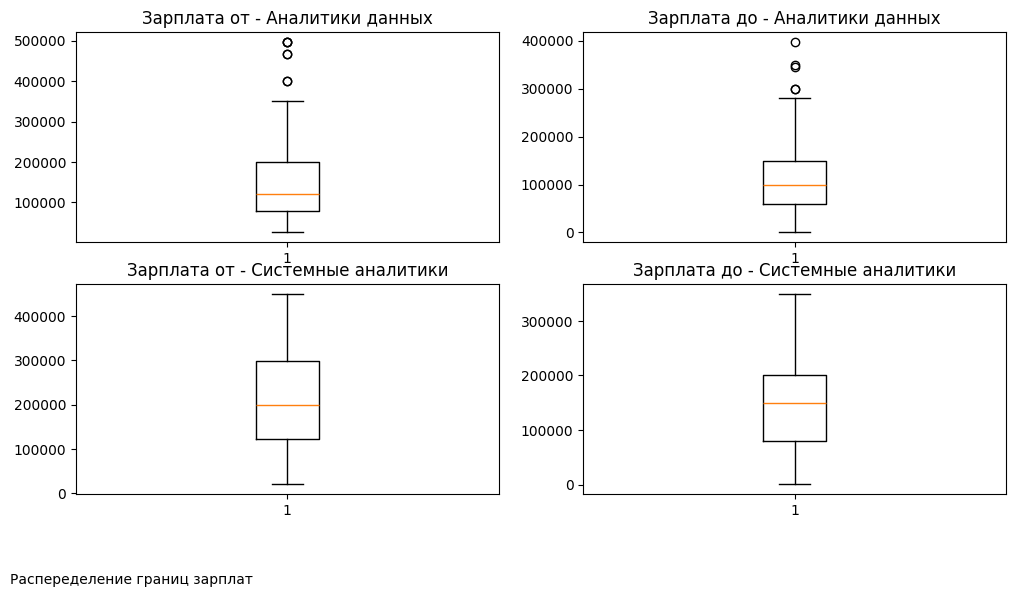

In [24]:
# Задаем ячейки и размеры графиков
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12, 6)) 

# Ящик с усами для столбца зарплата от (нижняя граница)
ax1.boxplot(da_salary['salary_to'])
ax1.set_title('Зарплата от - Аналитики данных')

# Ящик с усами для столбца зарплата до (верхняя граница)
ax2.boxplot(da_salary['salary_from'])
ax2.set_title('Зарплата до - Аналитики данных')

# Ящик с усами для столбца зарплата от (нижняя граница)
ax3.boxplot(sa_salary['salary_to'])
ax3.set_title('Зарплата от - Системные аналитики')

# Ящик с усами для столбца зарплата до (верхняя граница)
ax4.boxplot(sa_salary['salary_from'])
ax4.set_title('Зарплата до - Системные аналитики')

# Указываем подпись на графике
txt = 'Распеределение границ зарплат'

# Задаем расположение подписи
fig.text(0.07,-0.04,txt)

# Задаем расстояние между графиками
plt.subplots_adjust()

# Выводим график
plt.show()

Так как медианные зарплаты у системных аналитиков и аналитиков данных разные, то будем работать с пропусками для каждой профессии отдельно. Иначе в конечном счете у нас зарплата аналитиков данных может быть выше, чем есть на самом деле.

В этом случае заполним пропуски для каждого типа вакансий следующим образом:
* Для аналитиков данных в пропуски подставим 80000₽ в столбец `salary_to`, если `salary_from` указано 60000₽;
* Для системных аналитиков в пропуски подставим 120000₽ в столбец `salary_to`, если `salary_from` указано 80000₽.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3489 non-null   int64         
 1   name                              3489 non-null   object        
 2   published_at                      3489 non-null   datetime64[ns]
 3   alternate_url                     3489 non-null   object        
 4   type                              3489 non-null   object        
 5   employer                          3489 non-null   object        
 6   department                        3489 non-null   object        
 7   area                              3489 non-null   object        
 8   experience                        3489 non-null   object        
 9   key_skills                        3489 non-null   object        
 10  schedule                          3489 non-null   obj

In [26]:
# Заполним пустые значения для аналитиков данных
df.loc[(df['prof'] == 'da') & (df['salary_from'] == 60000) & (df['salary_to'].isna()), 'salary_to'] = 80000
df.loc[(df['prof'] == 'da') & (df['salary_to'] == 80000) & (df['salary_from'].isna()), 'salary_from'] = 60000
df.loc[(df['prof'] == 'da') & (df['salary_from'] == 100000) & (df['salary_to'].isna()), 'salary_to'] = 120000
df.loc[(df['prof'] == 'da') & (df['salary_to'] == 120000) & (df['salary_from'].isna()), 'salary_from'] = 100000
df.loc[(df['prof'] == 'da') & (df['salary_from'] == 150000) & (df['salary_to'].isna()), 'salary_to'] = 200000
df.loc[(df['prof'] == 'da') & (df['salary_to'] == 200000) & (df['salary_from'].isna()), 'salary_from'] = 150000

# Заполним пустые значения для системных аналитиков
df.loc[(df['prof'] == 'sa') & (df['salary_from'] == 80000) & (df['salary_to'].isna()), 'salary_to'] = 120000
df.loc[(df['prof'] == 'sa') & (df['salary_to'] == 120000) & (df['salary_from'].isna()), 'salary_from'] = 80000
df.loc[(df['prof'] == 'sa') & (df['salary_from'] == 150000) & (df['salary_to'].isna()), 'salary_to'] = 200000
df.loc[(df['prof'] == 'sa') & (df['salary_to'] == 200000) & (df['salary_from'].isna()), 'salary_from'] = 150000
df.loc[(df['prof'] == 'sa') & (df['salary_from'] == 200000) & (df['salary_to'].isna()), 'salary_to'] = 300000
df.loc[(df['prof'] == 'sa') & (df['salary_to'] == 300000) & (df['salary_from'].isna()), 'salary_from'] = 200000

Заполняем остальные пропуски по принципу если максимальная заполнена, то можно указать такую же сумму минимальной, так как вероятно ниже этой суммы работодатель не предложит.

In [27]:
# Функция для восстановления пропусков зарплаты и расчет средней
def make_salary_avg(row):
    # Присваеваем переменные минимальной и максимальной зарплаты
    salary_min = row['salary_from']
    salary_max = row['salary_to']

    if pd.isna(salary_min) and pd.isna(salary_max):
        return np.nan
    # Возвращаем максимальную
    elif pd.isna(salary_min):
        return salary_max
    # Возвращаем минимальную
    elif pd.isna(salary_max):
        return salary_min
    # Рассчитываем среднюю заработную плату
    else:
        return (salary_min + salary_max) / 2

df['salary_avg'] = df.apply(make_salary_avg, axis=1)

In [28]:
# Проверим пропуски после обработки
df.isna().sum().sort_values()

id                                     0
soft_skills_from_description           0
hard_skills_from_description           0
key_skills_from_key_skills_field       0
salary_bin                             0
description_lemmatized                 0
description                            0
employment                             0
prof                                   0
schedule                               0
experience                             0
area                                   0
department                             0
employer                               0
type                                   0
alternate_url                          0
published_at                           0
name                                   0
key_skills                             0
salary_avg                          2670
salary_from                         2792
salary_to                           2913
dtype: int64

Таким образом нам удалось восстановить ~300 пропусков в данных. К сожадению больше ничего мы не можем восстановить и поэтому будем работать с тем, что есть. 

### Обработка категориальных данных

В ходе обзора датасетов были так же выявлены человеческие ошибки при заполнения поля `experience` с грейдами. Например: 

In [29]:
# Вывод некорректных строк
display(df.query('id == [103567678, 101366700, 100596801, 101452479, 102836639, 99588910]'))

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,prof,salary_avg
41,100596801,Ведущий системный аналитик,2024-06-27 11:11:17,https://hh.ru/vacancy/100596801,Открытая,БФТ-Холдинг (Бюджетные и Финансовые Технологии),неизвестно,Ижевск,Junior+ (1-3 years),"['confluence', 'Документация']",...,бфт-холдинг (входит в группу компаний «ростеле...,бфт холдинг входить группа компания ростелеком...,NaN,NaN,ЗП не указана,неизвестно,confluence,Документация,sa,NaN
153,101366700,Старший системный аналитик,2024-07-08 18:18:30,https://hh.ru/vacancy/101366700,Открытая,edna,неизвестно,Москва,Middle (3-6 years),"['confluence', 'Системный анализ', 'Документац...",...,edna – ведущий поставщик решений в области циф...,edna ведущий поставщик решение область цифрово...,NaN,NaN,ЗП не указана,Системный анализ,confluence,"Коммуникация, Документация",sa,NaN
189,101452479,Junior+/Middle System Analyst/Системный Аналитик,2024-07-02 10:55:27,https://hh.ru/vacancy/101452479,Открытая,ИНФИНАЙТ СИНЕРДЖИ,неизвестно,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",...,"infinite synergy — it решения, где встречаются...",infinite synergy it решение встречаться партне...,100000.0,250000.0,От 200 тысяч до 300 тысяч,"Анализ данных, SQL, Разработка технических зад...",неизвестно,Документация,sa,175000.0
516,102836639,Системный аналитик/System Analyst (junior),2024-06-27 11:05:04,https://hh.ru/vacancy/102836639,Открытая,Aston,неизвестно,Краснодар,Junior+ (1-3 years),"['SOA', 'XML', 'Atlassian Jira', 'Use cases', ...",...,системный аналитик / system analyst junior мы ...,системный аналитик system analyst junior аутсо...,80000.0,110000.0,От 100 тысяч до 200 тысяч,"Системный анализ, System Analysis, Use cases, ...",confluence,неизвестно,sa,95000.0
1316,103567678,Business analyst/System analyst (Junior+),2024-07-09 10:27:45,https://hh.ru/vacancy/103567678,Открытая,CCS (Center of Corporate Solution),неизвестно,Москва,Junior (no experince),[],...,о нас: мы занимаемся разработкой и поддержкой ...,заниматься разработка поддержка высоконагружен...,NaN,NaN,ЗП не указана,неизвестно,неизвестно,неизвестно,sa,NaN
3622,99588910,Data Analyst (middle/senior),2024-06-10 15:34:44,https://hh.ru/vacancy/99588910,Открытая,WILDBERRIES,неизвестно,Москва,Junior+ (1-3 years),"['ClickHouse', 'SQL']",...,wildberries — это крупнейшая в странах еаэс ме...,wildberries крупный страна еаэс международный ...,NaN,NaN,ЗП не указана,"SQL, ClickHouse",неизвестно,неизвестно,da,NaN


In [30]:
# Вывод уникальных грейдов
display(df.experience.unique())

array(['Middle (3-6 years)', 'Junior+ (1-3 years)', 'Senior (6+ years)',
       'Junior (no experince)'], dtype=object)

Для удобства анализа данных создадим новый столбец с грейдами на основе значений стобца `experience`:
* Middle 
* Junior+
* Senior
* Junior

In [31]:
# Создаем столбец `grade`
df['grade'] = df['experience'].str[:7].replace(' ', '', regex=True)

In [32]:
# Функция для починки грейдов

def set_grade(df):
    try:
        if ('senior' in df['name']) \
        & (df['grade'] == 'Middle') \
        & ('middle' not in df['name']):
            return 'Senior'
        elif ('senior' in df['name']) \
        & (df['grade'] != 'Senior') \
        & ('middle' in df['name']):
            return 'Middle'
        elif (('Старший' in df['name']) \
        or ('Ведущий' in df['name'])) \
        & (df['grade'] != 'Senior'):
            return 'Senior'
        elif (df['name'] == 'Business analyst/System analyst (Junior+)') \
        & (df['grade'] == 'Junior'):
            return 'Junior+'
        elif ('+' not in df['name']) \
        & ('junior' in df['name']) \
        & (df['grade'] == 'Junior+'):
            return 'Junior'
        else:
            return df['grade']
    except:
        pass
    
df['grade'] = df.apply(set_grade, axis = 1)

In [33]:
# Проверяем изменения
df.query('id == [103567678, 101366700, 100596801, 101452479, 102836639, 99588910]')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,prof,salary_avg,grade
41,100596801,Ведущий системный аналитик,2024-06-27 11:11:17,https://hh.ru/vacancy/100596801,Открытая,БФТ-Холдинг (Бюджетные и Финансовые Технологии),неизвестно,Ижевск,Junior+ (1-3 years),"['confluence', 'Документация']",...,бфт холдинг входить группа компания ростелеком...,NaN,NaN,ЗП не указана,неизвестно,confluence,Документация,sa,NaN,Senior
153,101366700,Старший системный аналитик,2024-07-08 18:18:30,https://hh.ru/vacancy/101366700,Открытая,edna,неизвестно,Москва,Middle (3-6 years),"['confluence', 'Системный анализ', 'Документац...",...,edna ведущий поставщик решение область цифрово...,NaN,NaN,ЗП не указана,Системный анализ,confluence,"Коммуникация, Документация",sa,NaN,Senior
189,101452479,Junior+/Middle System Analyst/Системный Аналитик,2024-07-02 10:55:27,https://hh.ru/vacancy/101452479,Открытая,ИНФИНАЙТ СИНЕРДЖИ,неизвестно,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",...,infinite synergy it решение встречаться партне...,100000.0,250000.0,От 200 тысяч до 300 тысяч,"Анализ данных, SQL, Разработка технических зад...",неизвестно,Документация,sa,175000.0,Junior+
516,102836639,Системный аналитик/System Analyst (junior),2024-06-27 11:05:04,https://hh.ru/vacancy/102836639,Открытая,Aston,неизвестно,Краснодар,Junior+ (1-3 years),"['SOA', 'XML', 'Atlassian Jira', 'Use cases', ...",...,системный аналитик system analyst junior аутсо...,80000.0,110000.0,От 100 тысяч до 200 тысяч,"Системный анализ, System Analysis, Use cases, ...",confluence,неизвестно,sa,95000.0,Junior
1316,103567678,Business analyst/System analyst (Junior+),2024-07-09 10:27:45,https://hh.ru/vacancy/103567678,Открытая,CCS (Center of Corporate Solution),неизвестно,Москва,Junior (no experince),[],...,заниматься разработка поддержка высоконагружен...,NaN,NaN,ЗП не указана,неизвестно,неизвестно,неизвестно,sa,NaN,Junior+
3622,99588910,Data Analyst (middle/senior),2024-06-10 15:34:44,https://hh.ru/vacancy/99588910,Открытая,WILDBERRIES,неизвестно,Москва,Junior+ (1-3 years),"['ClickHouse', 'SQL']",...,wildberries крупный страна еаэс международный ...,NaN,NaN,ЗП не указана,"SQL, ClickHouse",неизвестно,неизвестно,da,NaN,Middle


**Выводы**

Удалось улучшить грейды, чтобы сделать анализ более точным.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3715
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3489 non-null   int64         
 1   name                              3489 non-null   object        
 2   published_at                      3489 non-null   datetime64[ns]
 3   alternate_url                     3489 non-null   object        
 4   type                              3489 non-null   object        
 5   employer                          3489 non-null   object        
 6   department                        3489 non-null   object        
 7   area                              3489 non-null   object        
 8   experience                        3489 non-null   object        
 9   key_skills                        3489 non-null   object        
 10  schedule                          3489 non-null   obj

## Анализ данных

In [35]:
# Для удобства работы с данными подготовим 
# два отдельных датафрейма для сравнения
# da_data = df.query('name_type == "da"')
# sa_data = df.query('name_type == "sa"')

### Определение доли грейдов

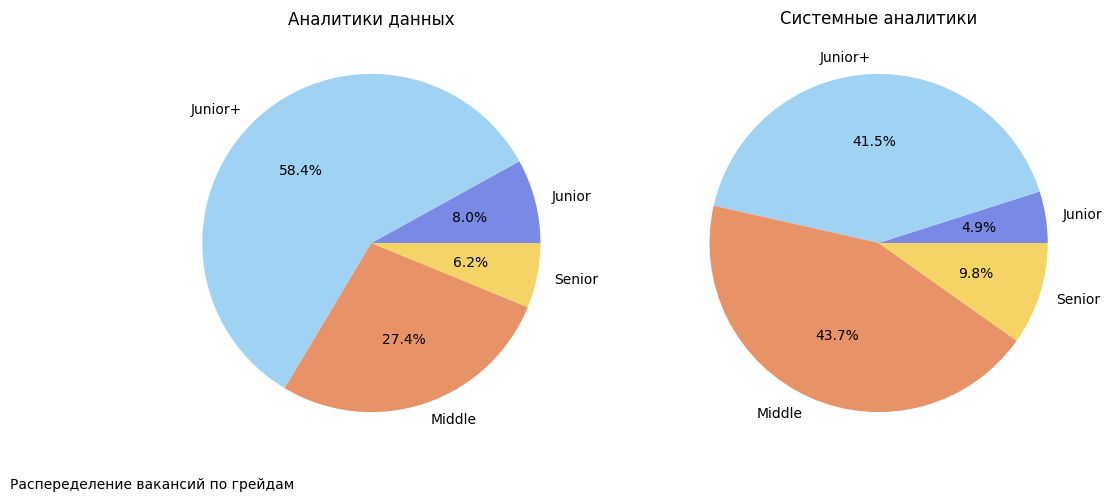

In [36]:
# Создадим сводную таблицу по типам вакансий
share_grades = df.pivot_table(index='grade', 
                              columns='prof',
                              values='id', 
                              aggfunc='count').reset_index()

# Задаем ячейки и размеры графиков
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 10)) 

colors = ['#7A88E6','#9FD2F3','#E89267', '#F3D465'] # задаем цвета
explode = (1, 0)

# Первый график — аналитики данных
labels = share_grades['grade'] # метки
values = share_grades['da'] # значения

ax1.pie(values,
        labels=labels,
        colors=colors,
        autopct = '%1.1f%%') 
ax1.set_title('Аналитики данных')

# Первый график — системные аналитики
labels = share_grades['grade'] # метки
values = share_grades['sa'] # значения
ax2.pie(values,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%') # круговая диаграмма 2
ax2.set_title('Системные аналитики')

# Указываем подпись на графике
txt = 'Распеределение вакансий по грейдам'

# Задаем расположение подписи
fig.text(0,0.25,txt)

# Выводим график
plt.show()

**Выводы**
1. Почти ~60% вакансий ищут junior+ по аналитике данных и всего 27% Middle;
2. У системных аналитиков почти поровно ищут специалистов junior+ и middle.

### Определение места работы

#### Распределение вакансий. ТОП-работодателей

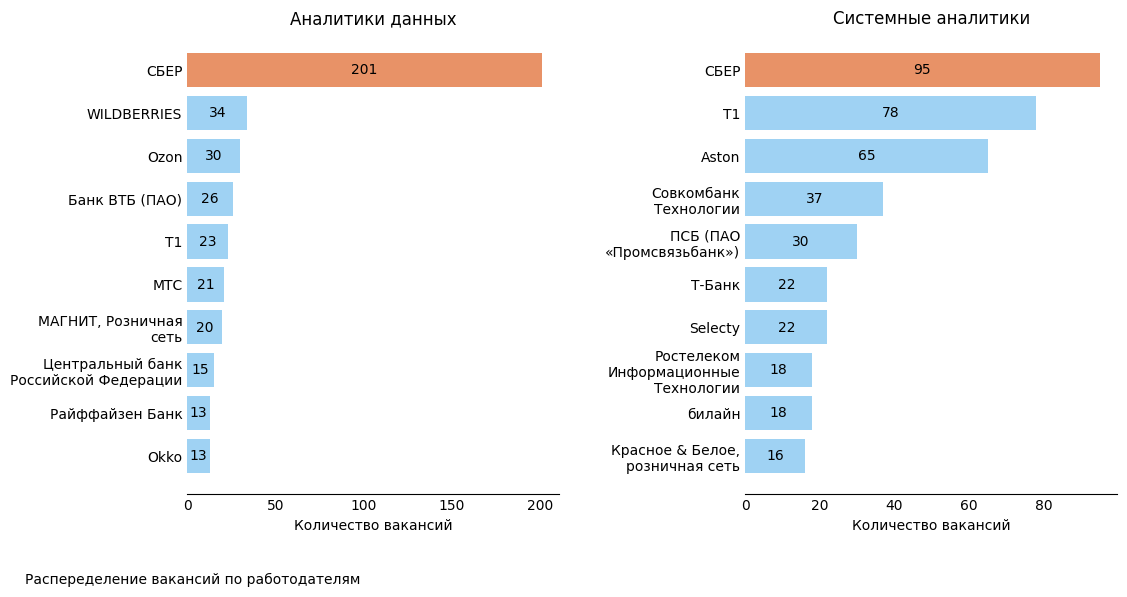

In [37]:
# Задаем ячейки и размеры графиков
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))

# Сгурппируем таблицу по аналитикам данных
employer_top_da = df.query('prof == "da"') \
                        .groupby('employer') \
                        .agg({'id': 'count'}) \
                        .rename(columns={'id':'da'}) \
                        .sort_values(by='da', ascending=False) \
                        .head(10) \
                        .sort_values(by='da', ascending=True) \
                        .reset_index()

# Сгурппируем таблицу по бизнес аналитикам
employer_top_sa = df.query('prof == "sa"') \
                        .groupby('employer') \
                        .agg({'id': 'count'}) \
                        .rename(columns={'id':'sa'}) \
                        .sort_values(by='sa', ascending=False) \
                        .head(10) \
                        .sort_values(by='sa', ascending=True) \
                        .reset_index() 

colors1 = ['#9FD2F3' if (x < max(employer_top_da['da'])) else '#E89267' for x in employer_top_da['da']]
colors2 = ['#9FD2F3' if (x < max(employer_top_sa['sa'])) else '#E89267' for x in employer_top_sa['sa']]

labels1 = employer_top_da['employer']
labels1 = ['\n'.join(wrap(l, 20)) for l in labels1]

# Построим график для аналитиков данных
ax1.barh(labels1, employer_top_da['da'], color=colors1)
ax1.set_title("Аналитики данных") # Заголовок
ax1.bar_label(ax1.containers[0], label_type='center') # Добавим значения на бары
ax1.set_xlabel('Количество вакансий')
ax1.grid(False)
ax1.tick_params(axis='both', which='both', length=0)

ax1.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax1.spines.top.set_visible(False)

labels2 = employer_top_sa['employer']
labels2 = ['\n'.join(wrap(l, 20)) for l in labels2]

# Построим график для системных аналитиков
ax2.barh(labels2, employer_top_sa['sa'], color=colors2)
ax2.set_title("Системные аналитики") # Заголовок
ax2.set_xlabel('Количество вакансий')
ax2.bar_label(ax2.containers[0], label_type='center') # Добавим значения на бары
ax2.yaxis.tick_left() # добавим названия компаний справа
ax2.tick_params(axis='both', which='both', length=0)

ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.spines.top.set_visible(False)

# Задаем расстояние между графиками
plt.subplots_adjust(wspace=0.5)

# Указываем подпись на графике
txt = 'Распеределение вакансий по работодателям'

# Задаем расположение подписи
fig.text(-0.01,-0.04,txt)

# Выводим график
plt.show()

In [38]:
# Функция для получения 8 графиков
def grade(df_group, dimensions, set_title):
    
    fig, ax = plt.subplots(2, 4, figsize=(25, 15))
    
    plt.suptitle(set_title)
        
    grade_set = df['grade'].unique() # задаем категориальные значения
    
    for i in range(len(grade_set)):
        
        da_filtered = (df.loc[(df['prof']=='da') & 
                              (df['grade']==f'{grade_set[i]}'), 
                              dimensions].value_counts()).reset_index().head(10)
        sa_filtered = (df.loc[(df['prof']=='sa') & 
                              (df['grade']==f'{grade_set[i]}'), 
                              dimensions].value_counts()).reset_index().head(10)        
        
        sns.barplot(x='count', y=dimensions, data=da_filtered, ax=ax[0, i], color='#E89267')
        ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
        ax[0, i].set_title(f"Аналитики данных, {grade_set[i]}", fontsize=14)
        ax[0, i].set_xlabel('')
        ax[0, i].set_ylabel('')
        ax[0, i].tick_params(axis='both', which='both', length=0)
        ax[0, i].bar_label(ax[0, i].containers[0], label_type='center')
        ax[0, i].grid(False)
        ax[0, i].spines.right.set_visible(False)
        ax[0, i].spines.left.set_visible(False)
        ax[0, i].spines.top.set_visible(False)

        sns.barplot(x='count', y=dimensions, data=sa_filtered, ax=ax[1, i], color='#9FD2F3')
        ax[1, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[1, i].get_yticklabels())
        ax[1, i].set_xlabel('')
        ax[1, i].set_ylabel('')
        ax[1, i].set_title(f"Системные аналитики, {grade_set[i]}", fontsize=14)
        ax[1, i].tick_params(axis='both', which='both', length=0)
        ax[1, i].bar_label(ax[1, i].containers[0], label_type='center')
        ax[1, i].grid(False)
        ax[1, i].spines.right.set_visible(False)
        ax[1, i].spines.left.set_visible(False)
        ax[1, i].spines.top.set_visible(False)   

    
    # Задаем отступы между ячейками
    plt.subplots_adjust(wspace = 0.5)
    
    # Указываем подпись на графике
#     txt = 'Распеределение вакансий по работодателям  в разрезе грейдов'

    # Задаем расположение подписи
#     fig.text(0.1,-0.01,txt)
    
    # Выводим график
    plt.show()

#### Распределение вакансий по ТОП-работодателям в зависимости от грейда

/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[1, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.g

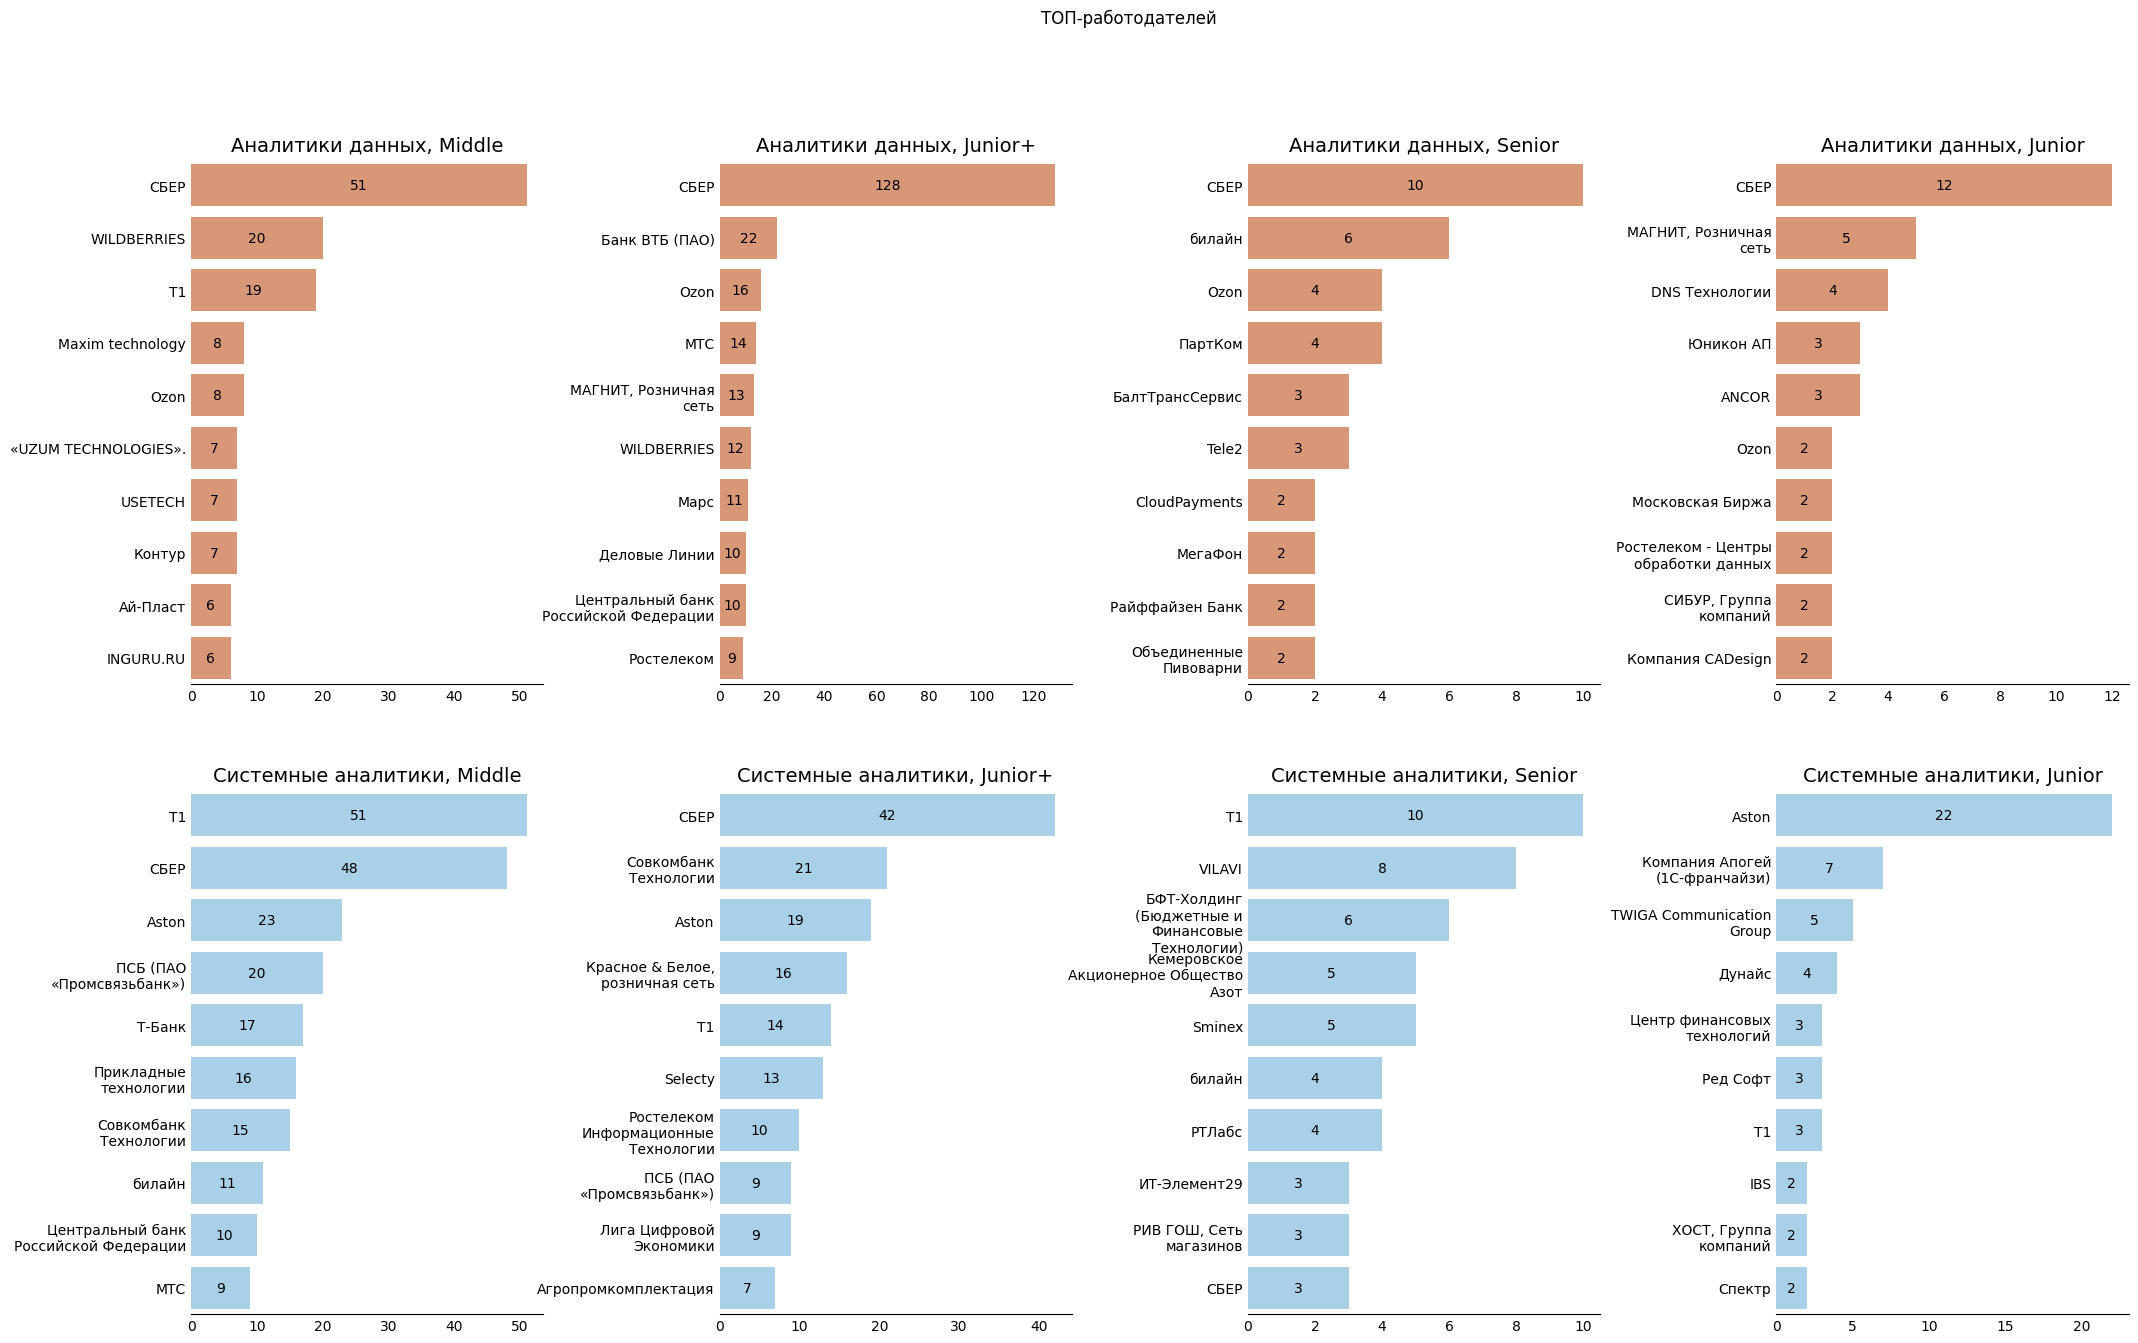

In [39]:
# Входящие данные
df_group = df
dimensions = 'employer'
set_title = 'ТОП-работодателей'

# Выводим график
grade(df_group, dimensions, set_title)

**Выводы**
1. На первом графике без грейдов больше всего аналитиков данных требуются в банковской сфере, где есть свои экосистемы и e-commerce. Системные аналитики также больше всего требуются банкам и в сфере FMCG;
2. На графике в разрезе грейдов больше всего вакансий представлено для Middle и Junior+ по обоим профессиям;

#### Распределение вакансий по зарплате в зависимости от грейда

/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[1, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.g

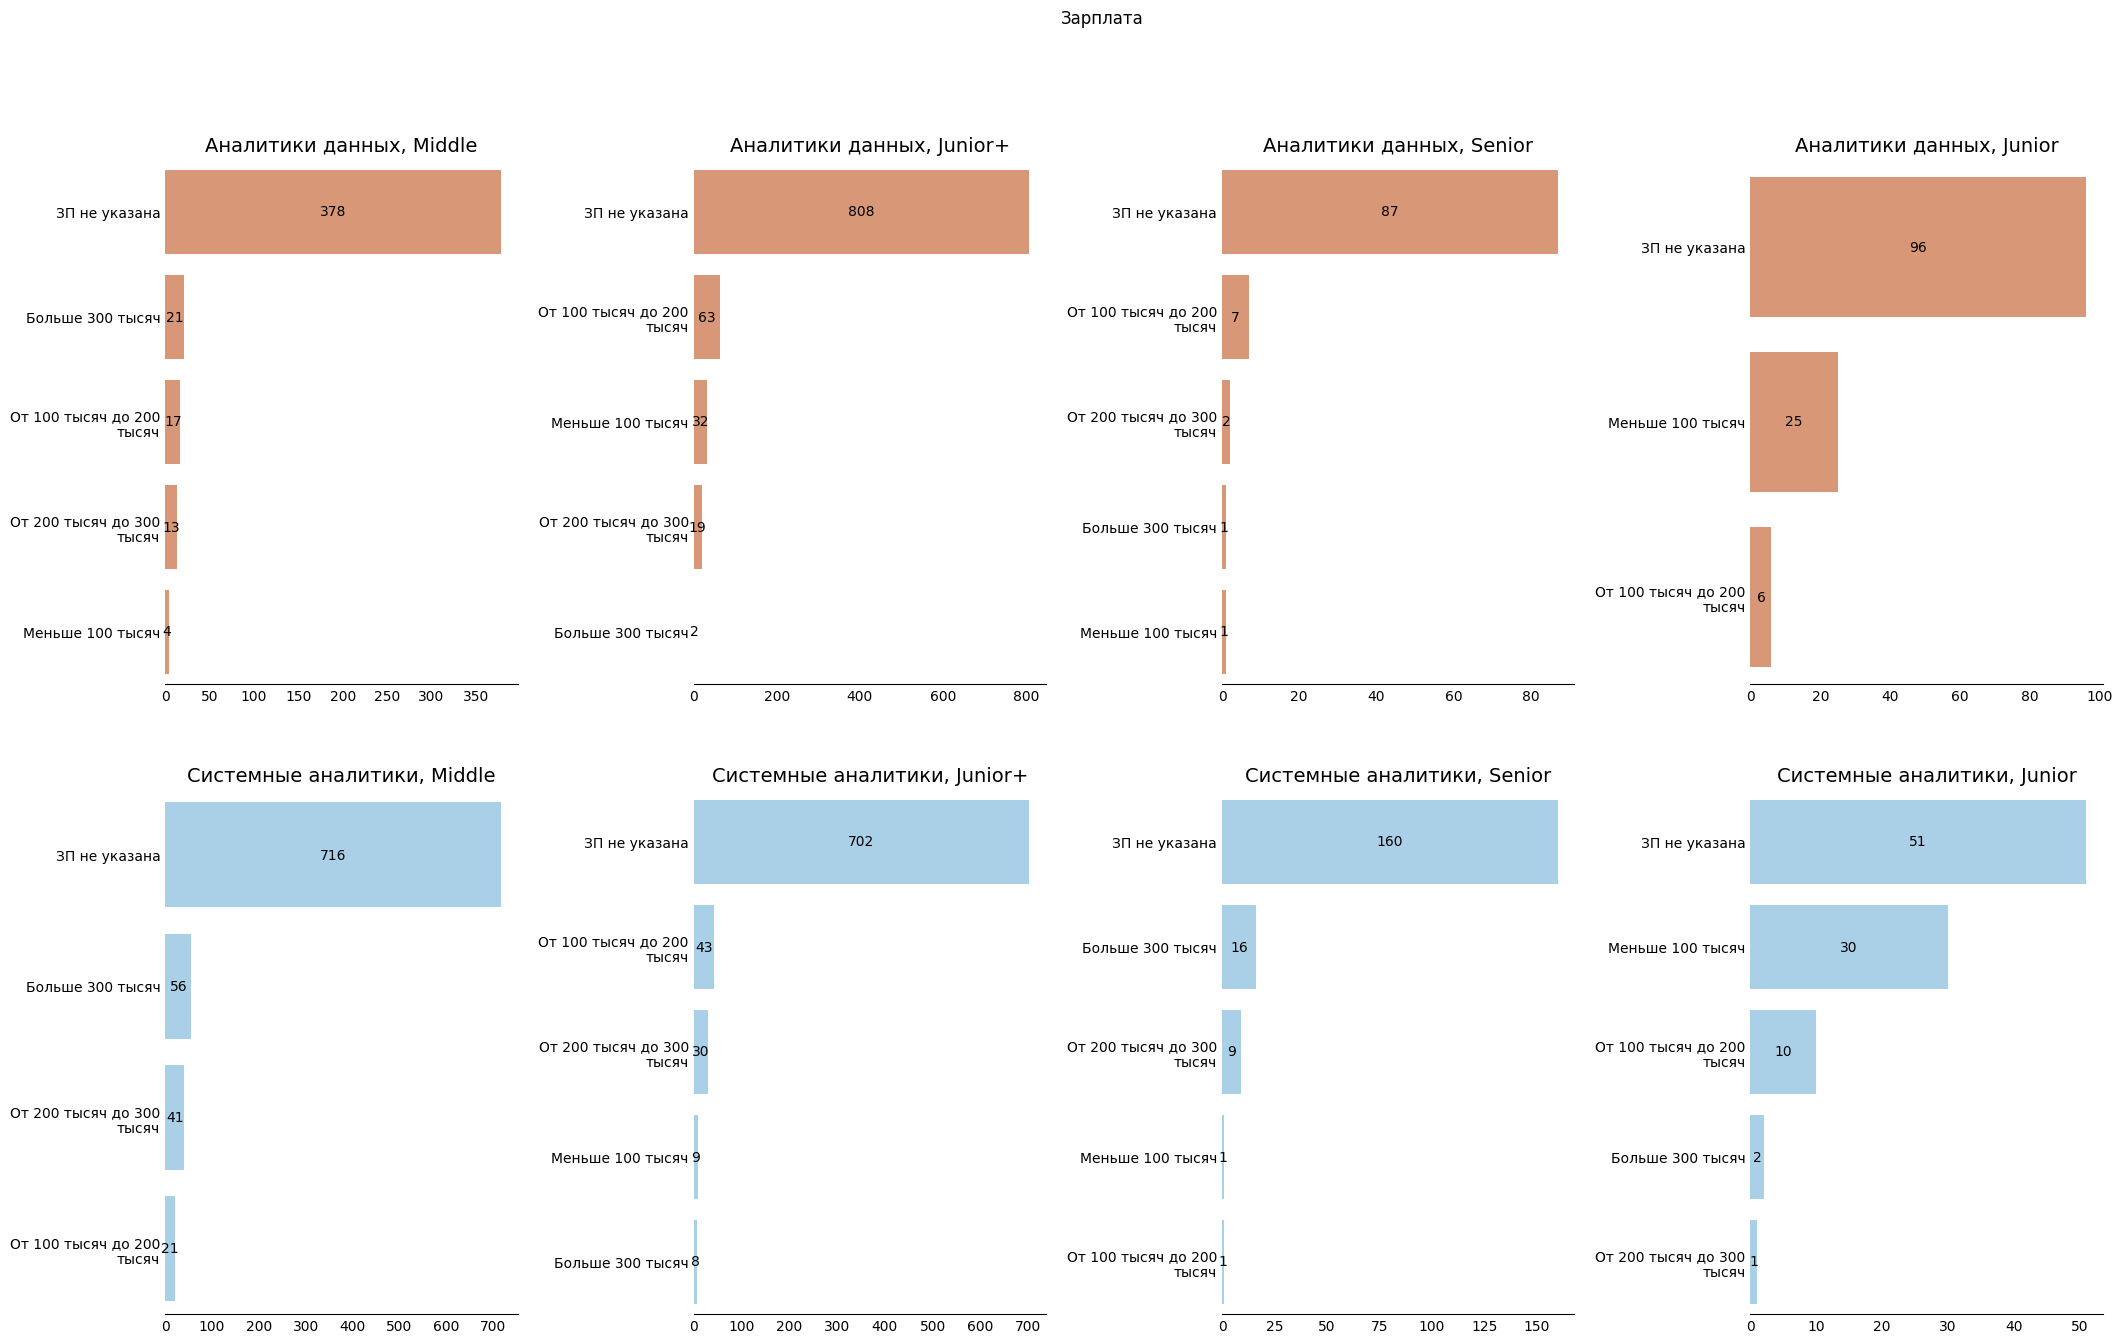

In [40]:
# Входящие данные
df_group = df
dimensions = 'salary_bin'
set_title = 'Зарплата'

# Выводим график
grade(df_group, dimensions, set_title)

**Выводы**

1. Чаще всего размер зарплаты не указывают для грейдов junior+ по обоим профессиям; 
2. У системных аналитиков также большая доля незаполненной зарплаты у middle;
3. Для обоих профессий характерно, что чем выше грейд, тем чаще не указывается размер оплаты.

#### Распределение вакансий по типу занятости в зависимости от грейда

/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[1, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.g

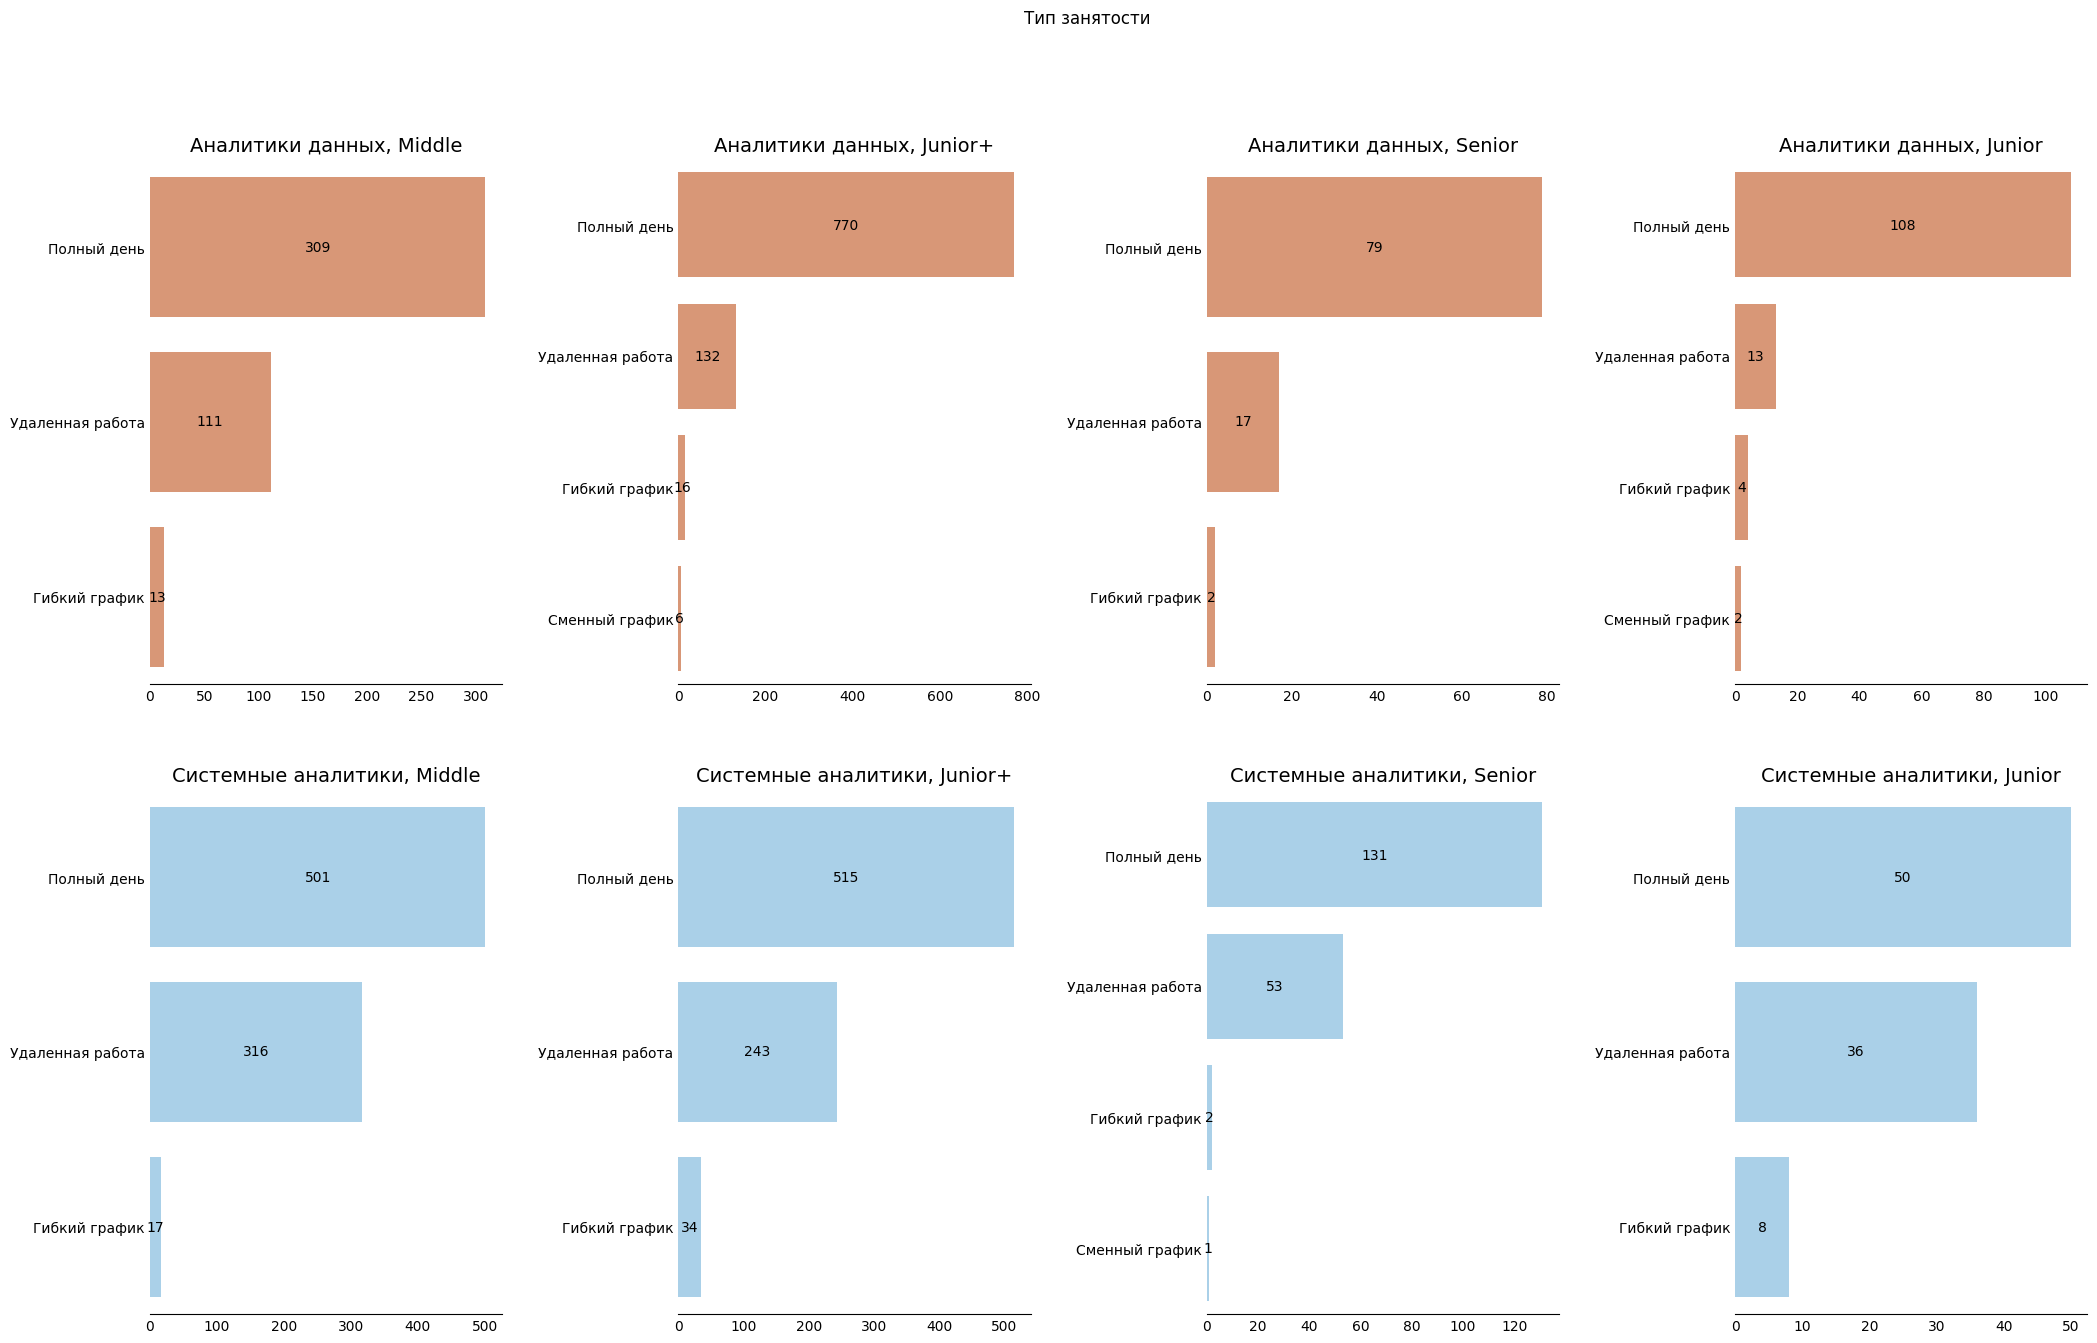

In [41]:
# Входящие данные
df_group = df
dimensions = 'schedule'
set_title = 'Тип занятости'

# Выводим график
grade(df_group, dimensions, set_title)

**Выводы**
* Чем ниже грейд, тем чаще работодатели требуют от соискателей работать в офисе;
* Гибридный график представлен меньше всего или почти отсутствует в большинстве грейдов;
* Для системных аналитиков почти половина вакансий для всех грейдов предлгают удаленную работу. А вот для аналитиков данных работодатели реже предлагают работать на удаленке даже для более опытных специалистов.

#### Распределение вакансий по типу графику работы в зависимости от грейда

/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[1, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_yticklabels(textwrap.fill(x.get_text(), 20) for x in ax[0, i].get_yticklabels())
/tmp/ipykernel_91045/2280762370.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, i].set_yticklabels(textwrap.fill(x.g

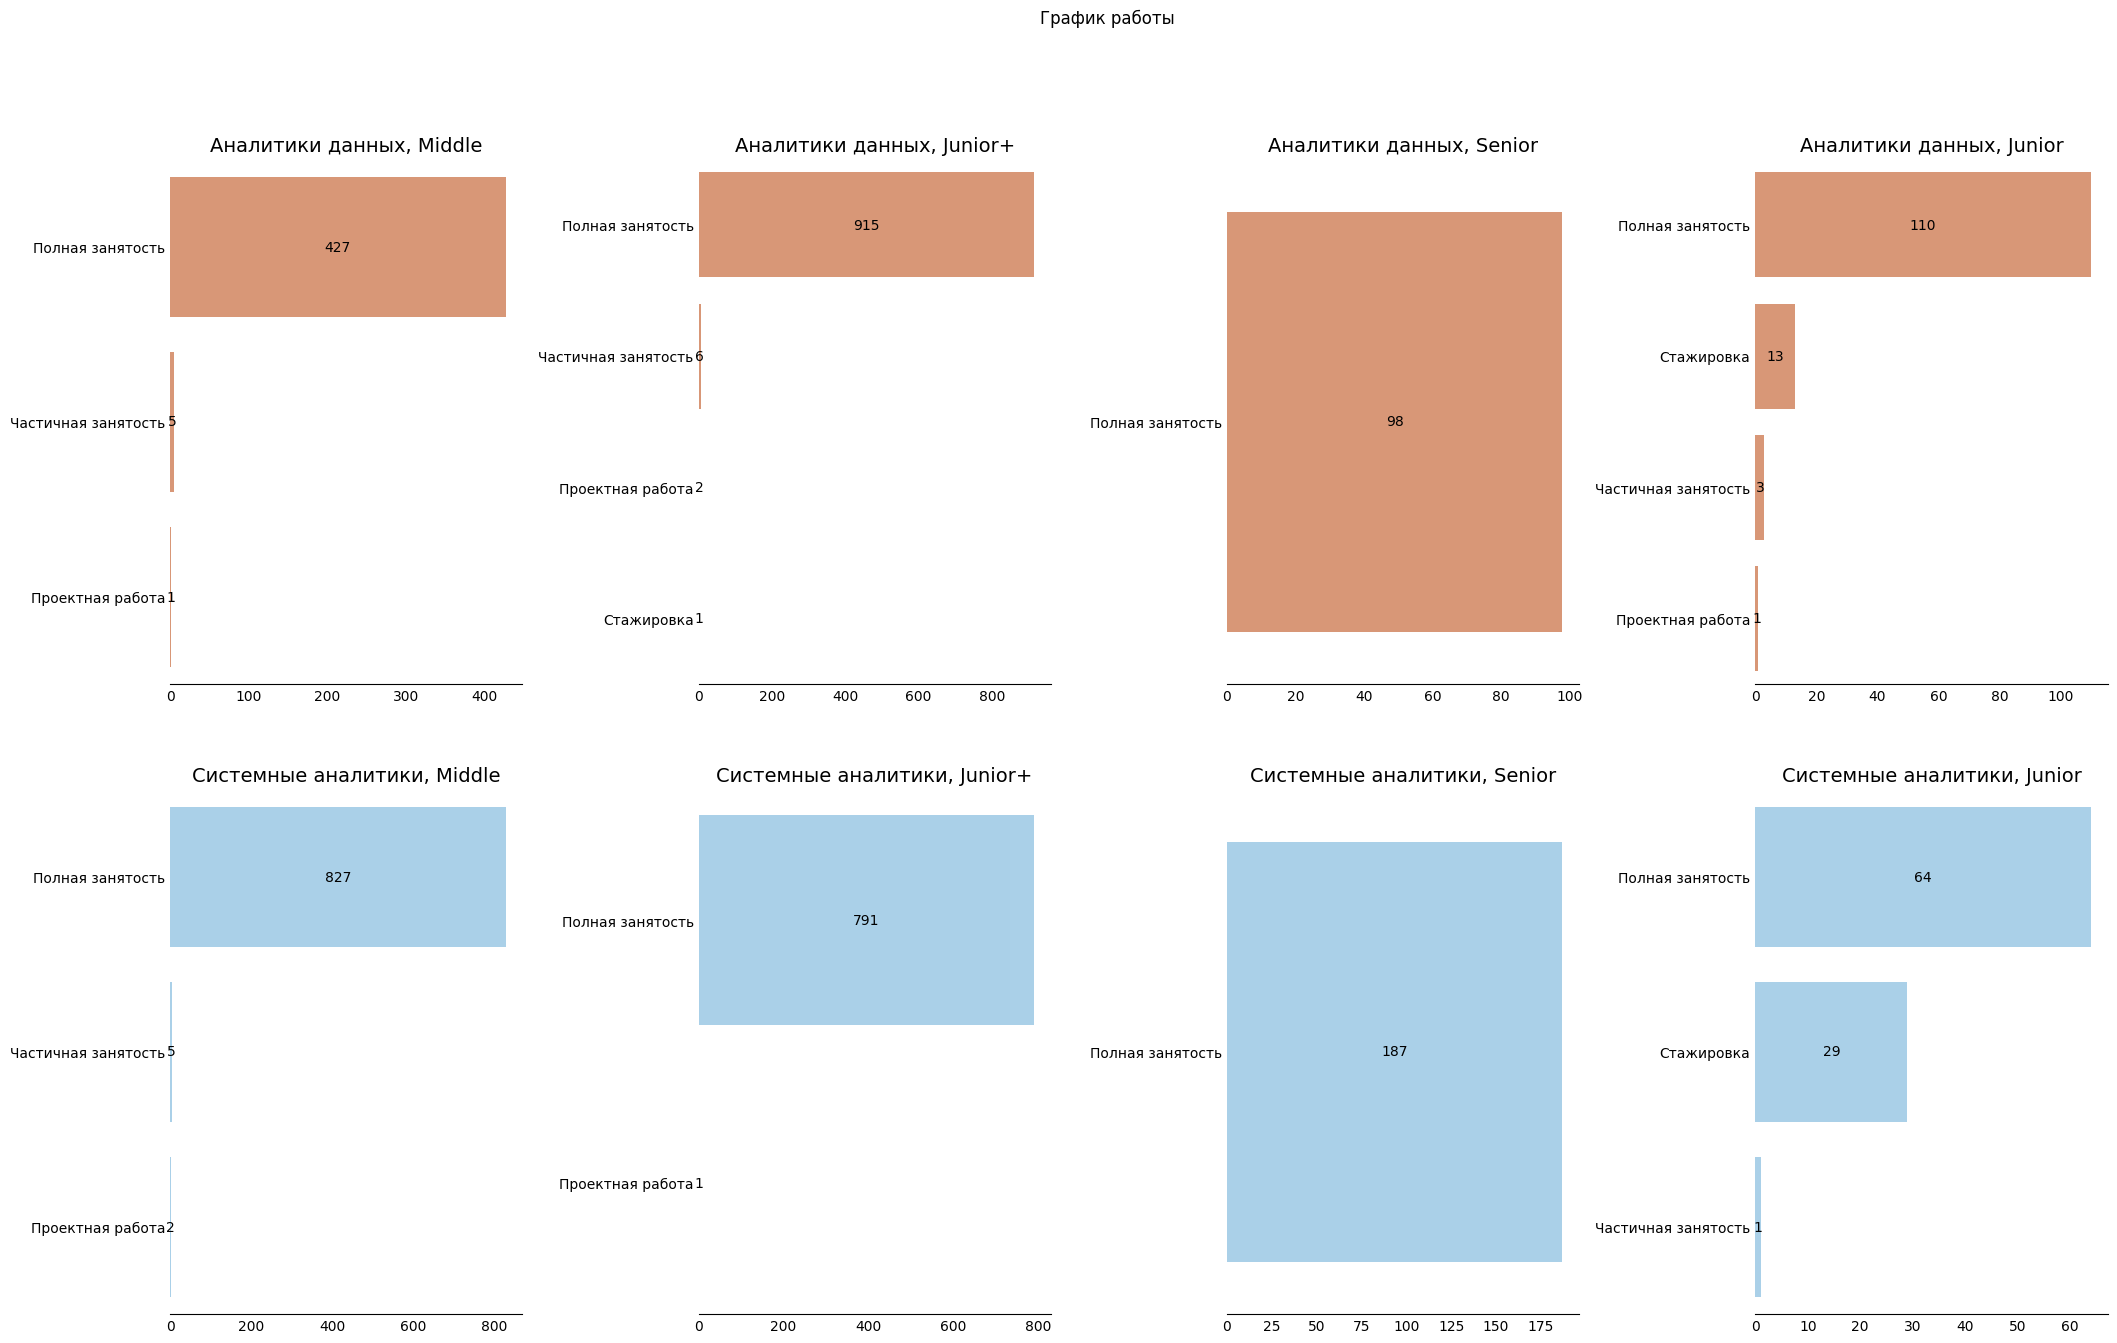

In [42]:
# Входящие данные
df_group = df
dimensions = 'employment'
set_title = 'График работы'

# Выводим график
grade(df_group, dimensions, set_title)

**Выводы**
Все работодатели для обоих профессия рассматривают в основном полную занятость. Отдельно для джунов предлагают больше вариантов — можно и проектно работать, а можно стажироваться.

### Определение навыков

#### Распределение вакансий по навыкам в зависимости от грейда

In [43]:
# Функция для парсинга «мягких» и «жестких» скилов
def make_skills(skill_list):
    if pd.isna(skill_list):
        return '', ''
    hard_sk = []
    soft_sk = []
    for skill in skill_list.split(','):
        skill = skill.strip()
        if skill:
            if skill.isascii():
                hard_sk.append(skill)
            else:
                soft_sk.append(skill)
    return ', '.join(hard_sk), ', '.join(soft_sk)

df[['hard_sk', 'soft_sk']] = df['key_skills_from_key_skills_field'].apply(make_skills).apply(pd.Series)

display(df.head(5))                           

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,prof,salary_avg,grade,hard_sk,soft_sk
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,неизвестно,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",...,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,неизвестно,sa,NaN,Middle,SQL,"Аналитический склад ума, 1С"
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,неизвестно,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",...,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",неизвестно,Документация,sa,NaN,Junior+,"BPMN, UML, REST, Atlassian Jira, API, Atlassia...","Английский язык, Системный анализ, Бизнес-анал..."
2,100059559,Системный IT аналитик,2024-07-08 11:48:17,https://hh.ru/vacancy/100059559,Открытая,AMarkets,неизвестно,Москва,Junior+ (1-3 years),['Документация'],...,NaN,ЗП не указана,неизвестно,неизвестно,Документация,sa,233750.0,Junior+,,неизвестно
3,100063260,Системный Аналитик ERP-решений,2024-07-09 10:51:54,https://hh.ru/vacancy/100063260,Открытая,Астор,неизвестно,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",...,NaN,ЗП не указана,"ERP, 1С: Управление Торговлей, Atlassian Jira,...",confluence,Коммуникация,sa,NaN,Senior,"ERP, Atlassian Jira, Atlassian Confluence","1С: Управление Торговлей, 1С: Предприятие: Роз..."
4,100064793,Системный аналитик,2024-07-08 16:39:40,https://hh.ru/vacancy/100064793,Открытая,Зетта Страхование,неизвестно,Москва,Junior+ (1-3 years),"['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...",...,NaN,ЗП не указана,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",неизвестно,неизвестно,sa,NaN,Junior+,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",


In [44]:
# Заполняем пропуски
df['hard_sk'] = df['hard_sk'].fillna('')
df['soft_sk'] = df['soft_sk'].fillna('')

In [45]:
# Заменим пустые значения в столбцах «мягких» и «жестких» скилов
df['hard_sk'] = df['hard_sk'].replace('', 'неизвестно')
df['soft_sk'] = df['soft_sk'].replace('', 'неизвестно')

In [46]:
# Приводим к нижнему регистру
df['hard_sk'] = df['hard_sk'].str.lower()
df['soft_sk'] = df['soft_sk'].str.lower()

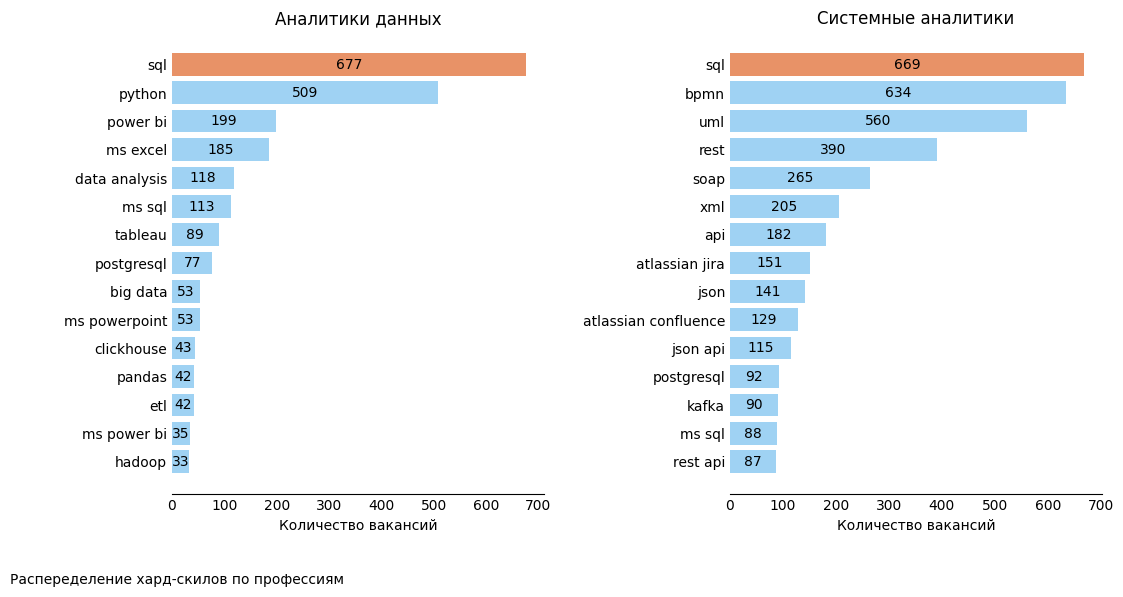

In [47]:
# Группируем вакансии по по профессиям 
hard_sk_sa = df[(df['prof']=='sa') & (df['hard_sk'] != 'неизвестно')]
hard_sk_sa = hard_sk_sa['hard_sk'] \
                                .str.lower().str.split(',') \
                                .explode().str.strip() \
                                .value_counts() \
                                .nlargest(15) \
                                .to_frame().reset_index()

hard_sk_da = df[(df['prof']=='da') & (df['hard_sk'] != 'неизвестно')]
hard_sk_da = hard_sk_da['hard_sk'] \
                            .str.lower().str.split(',') \
                            .explode().str.strip() \
                            .value_counts() \
                            .nlargest(15).to_frame().reset_index() 

# Объеденяем профессии по индексам
hard_sk_gropped = pd.merge(hard_sk_sa, hard_sk_da, left_index=True, right_index=True).sort_values(by='count_x', ascending=True)

# Задаем ячейки и размеры графиков
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))

colors1 = ['#9FD2F3' if (x < max(hard_sk_gropped['count_y'])) else '#E89267' for x in hard_sk_gropped['count_y']]
colors2 = ['#9FD2F3' if (x < max(hard_sk_gropped['count_x'])) else '#E89267' for x in hard_sk_gropped['count_x']]

labels1 = hard_sk_gropped['hard_sk_y']
labels1 = ['\n'.join(wrap(l, 20)) for l in labels1]

# Построим график для аналитиков данных
ax1.barh(labels1, hard_sk_gropped['count_y'], color=colors1)
ax1.set_title("Аналитики данных") # Заголовок
ax1.bar_label(ax1.containers[0], label_type='center') # Добавим значения на бары
ax1.set_xlabel('Количество вакансий')
ax1.grid(False)
ax1.tick_params(axis='both', which='both', length=0)

ax1.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax1.spines.top.set_visible(False)

labels2 = hard_sk_gropped['hard_sk_x']
labels2 = ['\n'.join(wrap(l, 20)) for l in labels2]

# Построим график для системных аналитиков
ax2.barh(labels2, hard_sk_gropped['count_x'], color=colors2)
ax2.set_title("Системные аналитики") # Заголовок
ax2.set_xlabel('Количество вакансий')
ax2.bar_label(ax2.containers[0], label_type='center') # Добавим значения на бары
ax2.yaxis.tick_left() # добавим названия компаний справа
ax2.tick_params(axis='both', which='both', length=0)

ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.spines.top.set_visible(False)

# Задаем расстояние между графиками
plt.subplots_adjust(wspace=0.5)

# Указываем подпись на графике
txt = 'Распеределение хард-скилов по профессиям'

# Задаем расположение подписи
fig.text(-0.01,-0.04,txt)

# Выводим график
plt.show()

**Выводы**
* Я выделил 15 навыков, чтобы список получился более расширенным и мы могли увидеть больше информации;
* По обоим специальностям больше всего требований к знанию sql. Дальше ситуация меняется. У системных аналитиков больше всего требований к bpmn, а у аналитиков данных — знание python. Также можно обратить внимание, что у аналитиков данных ms sql попал в отдельную позицию и по идее его можно было бы объеденить с первой строчкой. А у системных аналитиков такая ситуация с json. 

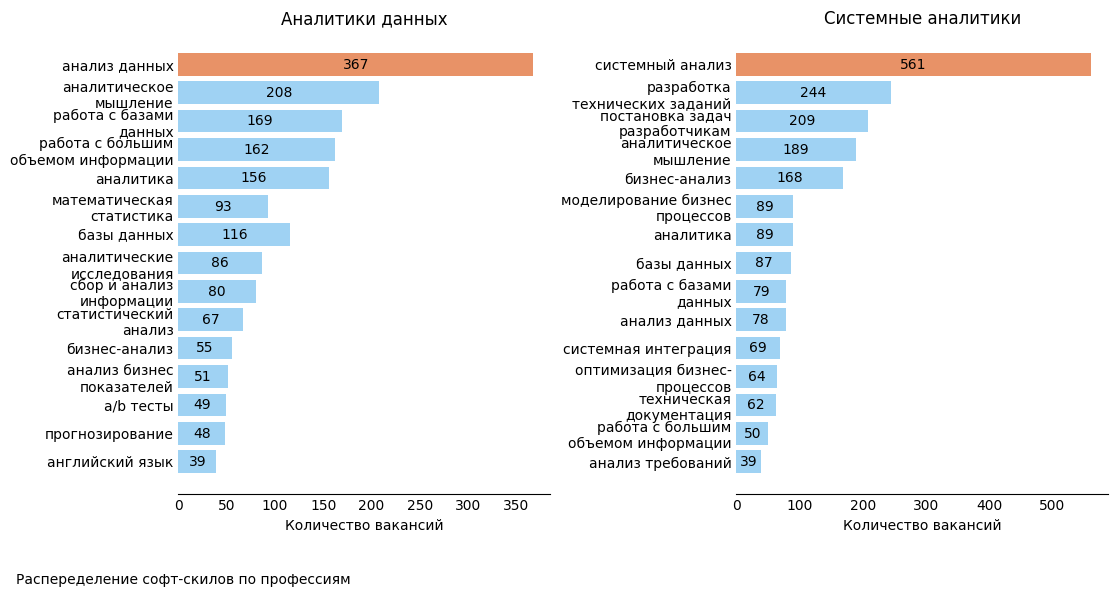

In [48]:
# Группируем вакансии по по профессиям 
soft_sk_sa = df[(df['prof']=='sa') & (df['soft_sk'] != 'неизвестно')]
soft_sk_sa = soft_sk_sa['soft_sk'] \
                                .str.lower().str.split(',') \
                                .explode().str.strip() \
                                .value_counts() \
                                .nlargest(15) \
                                .to_frame().reset_index()

soft_sk_da = df[(df['prof']=='da') & (df['soft_sk'] != 'неизвестно')]
soft_sk_da = soft_sk_da['soft_sk'] \
                            .str.lower().str.split(',') \
                            .explode().str.strip() \
                            .value_counts() \
                            .nlargest(15).to_frame().reset_index() 

# Объеденяем профессии по индексам
soft_sk_gropped = pd.merge(soft_sk_sa, soft_sk_da, left_index=True, right_index=True).sort_values(by='count_x', ascending=True)

# Задаем ячейки и размеры графиков
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))

colors1 = ['#9FD2F3' if (x < max(soft_sk_gropped['count_y'])) else '#E89267' for x in soft_sk_gropped['count_y']]
colors2 = ['#9FD2F3' if (x < max(soft_sk_gropped['count_x'])) else '#E89267' for x in soft_sk_gropped['count_x']]

labels1 = soft_sk_gropped['soft_sk_y']
labels1 = ['\n'.join(wrap(l, 20)) for l in labels1]

# Построим график для аналитиков данных
ax1.barh(labels1, soft_sk_gropped['count_y'], color=colors1)
ax1.set_title("Аналитики данных") # Заголовок
ax1.bar_label(ax1.containers[0], label_type='center') # Добавим значения на бары
ax1.set_xlabel('Количество вакансий')
ax1.grid(False)
ax1.tick_params(axis='both', which='both', length=0)

ax1.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax1.spines.top.set_visible(False)

labels2 = soft_sk_gropped['soft_sk_x']
labels2 = ['\n'.join(wrap(l, 20)) for l in labels2]

# Построим график для системных аналитиков
ax2.barh(labels2, soft_sk_gropped['count_x'], color=colors2)
ax2.set_title("Системные аналитики") # Заголовок
ax2.set_xlabel('Количество вакансий')
ax2.bar_label(ax2.containers[0], label_type='center') # Добавим значения на бары
ax2.yaxis.tick_left() # добавим названия компаний справа
ax2.tick_params(axis='both', which='both', length=0)

ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.spines.top.set_visible(False)

# Задаем расстояние между графиками
plt.subplots_adjust(wspace=0.5)

# Указываем подпись на графике
txt = 'Распеределение софт-скилов по профессиям'

# Задаем расположение подписи
fig.text(-0.01,-0.04,txt)

# Выводим график
plt.show()

**Вывод**
* Для аналитиков данных больше всего требований к: умению анализировать, аналитическое мышление, работа с базами данных и большими данными, а также знание математической статистики;
* Для системных аналитиков требования к мягким скилам: системный анализ, разработка ТЗ, аналитическое мышление и бизнес-анализ. 

In [49]:
df_da = df[df['prof'] == 'da']
df_sa = df[df['prof'] == 'sa']

In [50]:
experience_levels = df['grade'].unique()

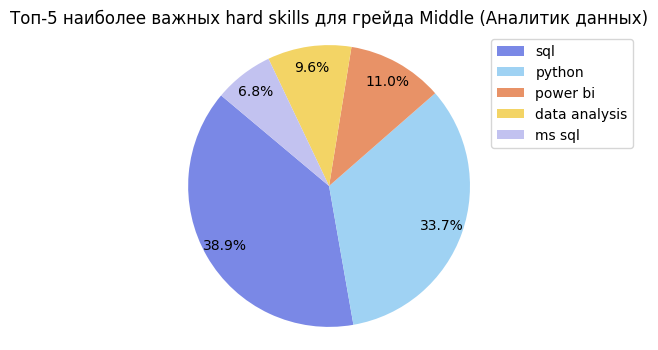

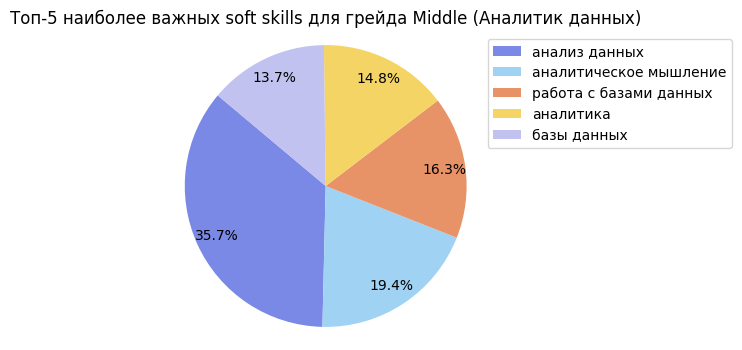

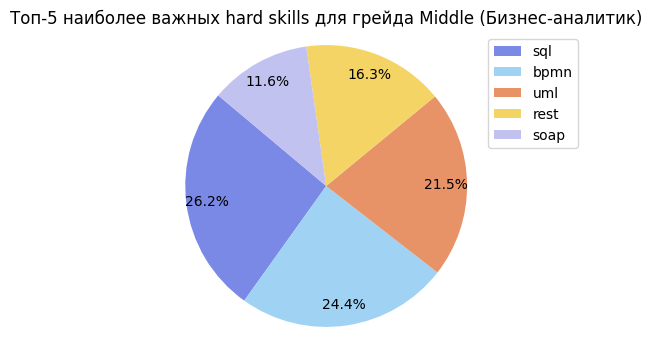

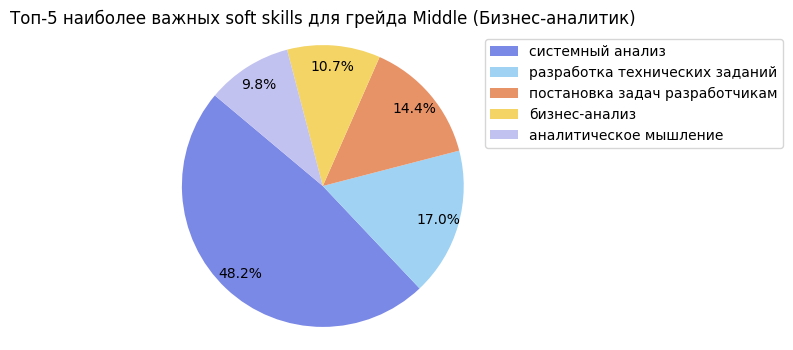

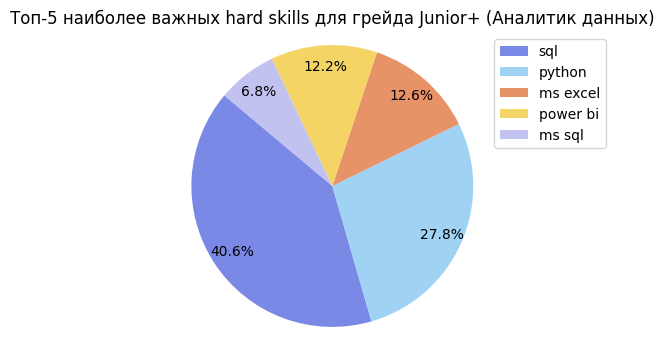

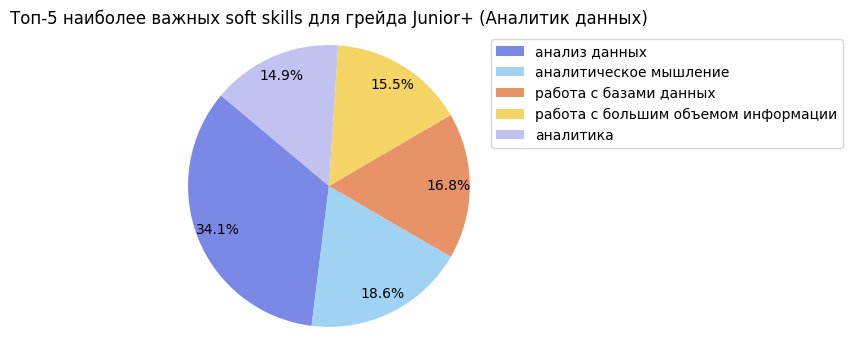

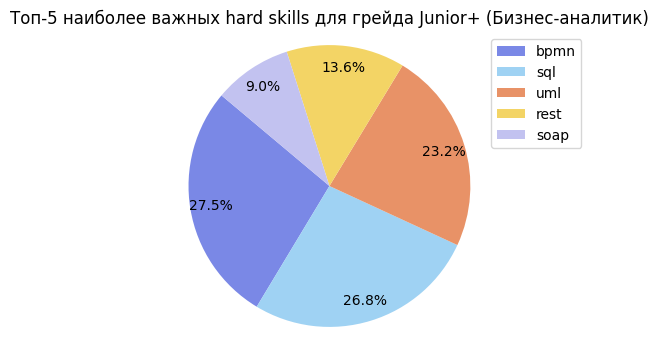

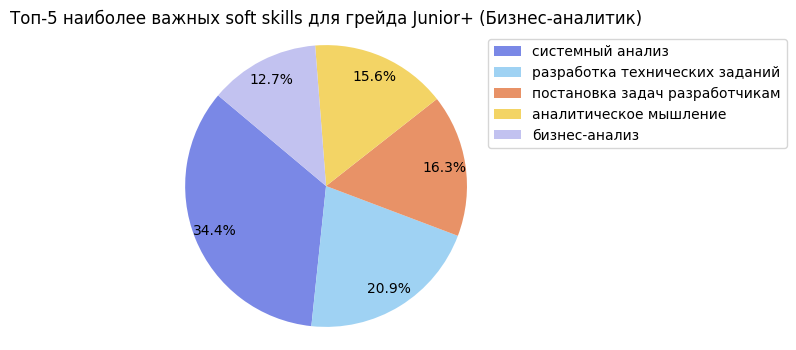

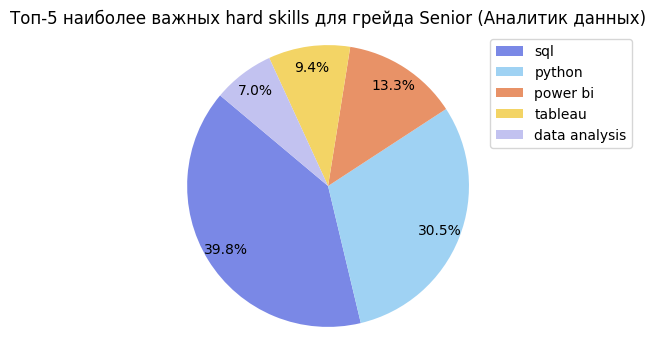

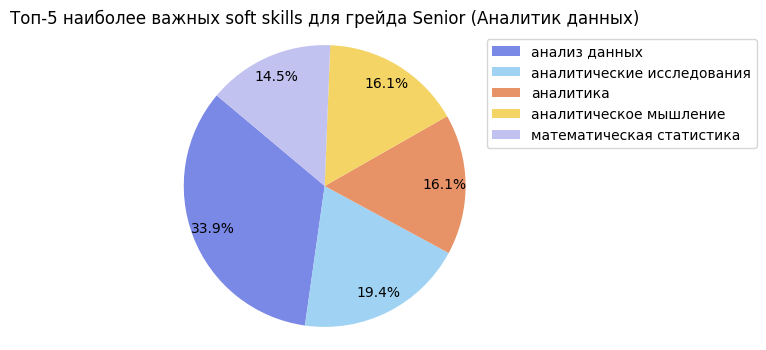

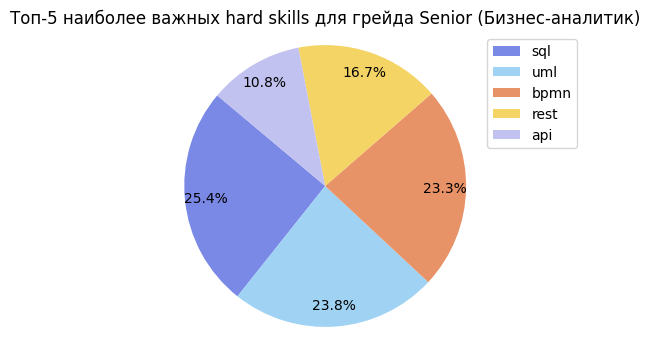

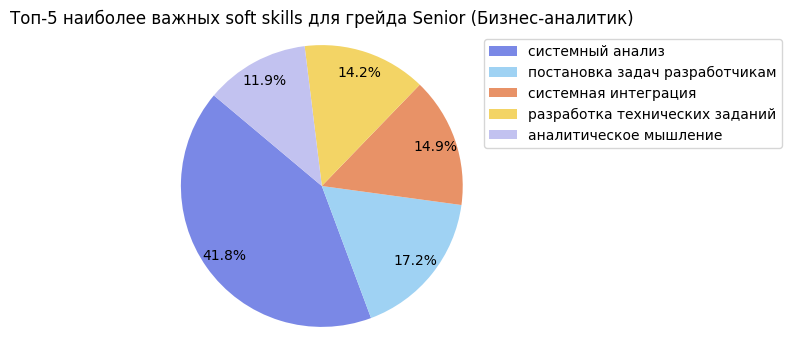

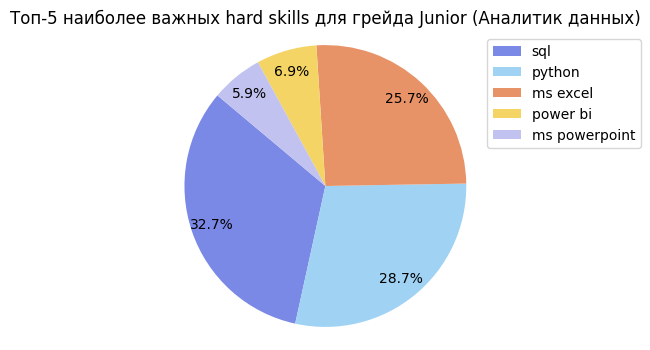

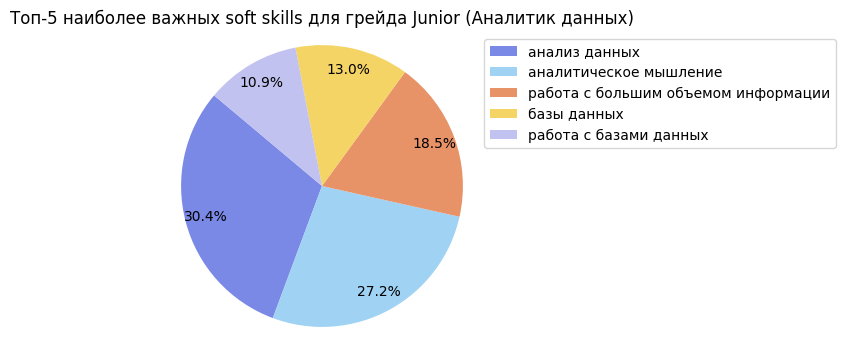

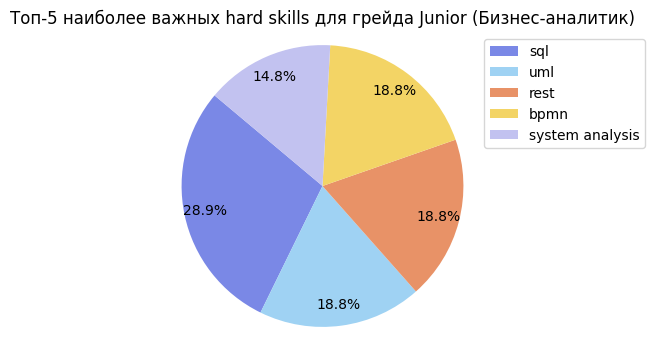

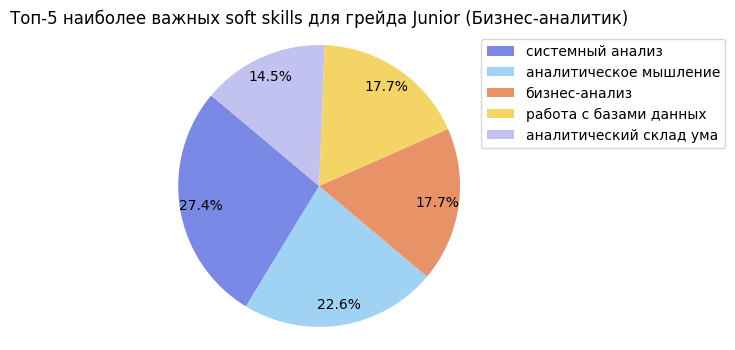

In [51]:
pastel_colors = ['#7A88E6','#9FD2F3','#E89267', '#F3D465', '#c2c2f0', '#ffb3e6', '#ffb3b3']

def plot_top_skills_pie(df, skill_column, n, title):
    # Объединение списков всех навыков для каждой строки
    all_skills = ','.join(df[skill_column].dropna()).split(',')
    # Убираем значения "отсутствует" и "не указано"
    all_skills = [skill.strip() for skill in all_skills if skill.lower() not in ['неизвестно']]
    # Создание Series из списка навыков и их количества
    skill_counts = pd.Series(all_skills).value_counts().head(n)

    # Визуализация топ-N навыков в виде круговой диаграммы с добавлением названий навыков
    plt.figure(figsize=(4, 4))
    patches, _, _ = plt.pie(skill_counts, labels=None, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labeldistance=1.1, colors=pastel_colors)
    plt.title(title)

    # Добавление легенды с названиями навыков
    plt.legend(skill_counts.index, loc='upper left', bbox_to_anchor=(1, 1))

    plt.axis('equal')  # Это для того, чтобы круг был кругом, а не эллипсом
    plt.show()

# Для каждого уровня грейда
for level in experience_levels:
    # Визуализация топ-5 наиболее важных hard skills для грейда Аналитик данных
    plot_top_skills_pie(df_da[df_da['grade'] == level], 'hard_sk', 5, f"Топ-5 наиболее важных hard skills для грейда {level} (Аналитик данных)")
    # Визуализация топ-5 наиболее важных soft skills для грейда Аналитик данных
    plot_top_skills_pie(df_da[df_da['grade'] == level], 'soft_sk', 5, f"Топ-5 наиболее важных soft skills для грейда {level} (Аналитик данных)")

    # Визуализация топ-5 наиболее важных hard skills для грейда Бизнес-аналитик
    plot_top_skills_pie(df_sa[df_sa['grade'] == level], 'hard_sk', 5, f"Топ-5 наиболее важных hard skills для грейда {level} (Бизнес-аналитик)")
    # Визуализация топ-5 наиболее важных soft skills для грейда Бизнес-аналитик
    plot_top_skills_pie(df_sa[df_sa['grade'] == level], 'soft_sk', 5, f"Топ-5 наиболее важных soft skills для грейда {level} (Бизнес-аналитик)")

**Выводы**

На основе предоставленных данных о наиболее важных hard и soft skills для каждого уровня грейда как для аналитиков данных, так и для системных-аналитиков, можно сделать следующие выводы:

Hard skills<br>
* Для уровня Junior наиболее значимым hard skills для аналитиков: sql, python, ms excel, power bi, ms powerpoint, а для системных аналитиков: sql, uml, rest, bpmn, system analysis;
* Для уровня Junior+ аиболее значимым hard skills для аналитиков: sql, python, ms excel, power bi, ms sql, а для бизнес-аналитиков - bpmn, sql, uml.
* Для уровня Middle наиболее важными hard skills для аналитиков данных и бизнес-аналитиков sql, bpmn, uml, rest, soap


Soft skills<br>
* Важные soft skills для всех уровней грейда включают аналитическое мышление и работу с большим объемом информации.
* Для аналитиков данных также важны навыки анализа данных и работы с базами данных.
* Для бизнес-аналитиков выделяются soft skills связанные с бизнес-анализом, моделированием бизнес-процессов и сбором и анализом информации.

Общие наблюдения: Некоторые hard skills, такие как SQL, Python и MS Excel, остаются важными на протяжении всей карьеры. Soft skills, такие как аналитическое мышление и работа с данными, также остаются важными на протяжении всей карьеры, но некоторые soft skills, связанные с бизнес-анализом, могут становиться более значимыми на более продвинутых уровнях.

[Презентация](https://fokus.am/p/wGwCZG7DeEG2)